# 1.1) DATA CLEANING

SETTING DIRECTORY AND IMPORTING LIBRARIES

In [ ]:
!pip install tabulate
!pip install pyLDAvis

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 21.3 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import spacy
from sklearn.feature_extraction.text import TfidfVectorizer
nlp = spacy.load('en_core_web_sm')
from spacy.tokens import Doc, Span
import numpy as np
import re
import os
from tabulate import tabulate
import pyLDAvis
import pyLDAvis.lda_model
from spacy.training import align
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from google.colab import drive
drive.mount('/content/drive')

drive_path = '/content/drive/MyDrive/Colab Notebooks/BERT TRIAL 2'

import pandas as pd
import spacy
nlp = spacy.load('en_core_web_sm')
from spacy.tokens import Doc, Span
from spacy.matcher import DependencyMatcher
from spacy.matcher import Matcher
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.preprocessing import LabelEncoder
import urllib.request
import zipfile
import os
from collections import Counter
from sklearn.utils.class_weight import compute_class_weight
import tensorflow as tf
from spacy.training import align
from google.colab import drive
drive.mount('/content/drive')
import matplotlib.pyplot as plt

drive_path = '/content/drive/MyDrive/Colab Notebooks/BERT TRIAL 2'

Mounted at /content/drive
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


CREATING DATAFRAMES FOR FILE1 AND FILE2

In [ ]:
file_path = os.path.join(drive_path, 'file1.ann')
file_path2 = os.path.join(drive_path, 'file2.ann')

def create_dataframe(content):
    with open(content, 'r', encoding='utf-8') as file:
        lines = file.readlines()
    data = [line.split() for line in lines]
    df = pd.DataFrame(data, columns=['token', 'tag'])
    df = df.drop(index=df.index[0])
    return df

df_file1 = create_dataframe(file_path)
df_file2 = create_dataframe(file_path2)

CLEANING FUNCTIONS FOR DATAFRAMES, ARAB CHARACTERS AND SPLITTING

In [ ]:
def pulisci_df(df):
    def is_arabic(word):
        if word is None or pd.isnull(word):
            return True
        word = str(word)
        return any('\u0600' <= char <= '\u06FF' for char in word)

    mask = df['token'].apply(is_arabic)
    return df[~mask]

df_file1 = pulisci_df(df_file1)
df_file1 = df_file1.reset_index(drop=True)

df_file2 = pulisci_df(df_file2)
df_file2 = df_file2.reset_index(drop= True)

def pulisci_file(df, column_name):
    result = df[column_name].str.cat(sep=' ')
    return result

file1_text = pulisci_file(df_file1, 'token')
file2_text = pulisci_file(df_file2, 'token')


SETTING UP SPACY AND TOKENIZATION

In [ ]:
doc1 = nlp(file1_text)
doc2 = nlp(file2_text)

CHANGE SPACY'S TAGGING SYSTEM TO IOB2 (ORIGINAL FORMAT OF THE DATASET) FOR FILE1 AND FILE 2

In [ ]:
original_tokens = df_file1["token"].tolist()
spacy_tokens = [token.text for token in doc1]

alignments = align.get_alignments(original_tokens, spacy_tokens)

aligned_iob2 = ["O"] * len(spacy_tokens)

for original_idx, spacy_indices in enumerate(alignments[0]):
    tag = df_file1["tag"][original_idx]
    if len(spacy_indices) == 1:
        aligned_iob2[spacy_indices[0]] = tag
    else:
        for idx in spacy_indices:
            aligned_iob2[idx] = tag

df_test1 = pd.DataFrame({'tokens': spacy_tokens, 'tag': aligned_iob2})

In [ ]:
original_tokens = df_file2["token"].tolist()
spacy_tokens = [token.text for token in doc2]

alignments = align.get_alignments(original_tokens, spacy_tokens)

aligned_iob2 = ["O"] * len(spacy_tokens)

for original_idx, spacy_indices in enumerate(alignments[0]):
    tag = df_file1["tag"][original_idx]
    if len(spacy_indices) == 1:
        aligned_iob2[spacy_indices[0]] = tag
    else:
        for idx in spacy_indices:
            aligned_iob2[idx] = tag

df_test2 = pd.DataFrame({'tokens': spacy_tokens, 'tag': aligned_iob2})

REPLACE DOC1 TAGS WITH THE ORIGINAL IOB2 TAGS

In [ ]:
def extract_entities(df, tag_column="tag"):
    entities = []
    current_entity = None

    for index, row in df.iterrows():
        tag = row[tag_column]

        if tag.startswith("B-"):  # Begin a new entity
            if current_entity:  # Save the previous entity
                entities.append(current_entity)
            entity_type = tag[2:]  # Extract the entity type
            current_entity = {"type": entity_type, "start": index, "end": index + 1}

        elif tag.startswith("I-") and current_entity:  # Inside an entity
            entity_type = tag[2:]
            if current_entity["type"] == entity_type:  # Ensure it's the same entity type
                current_entity["end"] = index + 1  # Extend the current entity

        else:  # Outside any entity
            if current_entity:  # Save the current entity
                entities.append(current_entity)
                current_entity = None

    # Add the last entity if it exists
    if current_entity:
        entities.append(current_entity)

    return entities

EXTRACTING ENTITIES FOR FILE1 AND FILE2 WITH FUNCTION ABOVE

In [ ]:
custom_entities1 = extract_entities(df_test1)

doc1.ents = [Span(doc1, entity["start"], entity["end"], label=entity["type"]) for entity in custom_entities1]
doc1.set_ents(doc1.ents, default="outside")

In [ ]:
custom_entities2 = extract_entities(df_test2)

doc2.ents = [Span(doc2, entity["start"], entity["end"], label=entity["type"]) for entity in custom_entities2]
doc2.set_ents(doc2.ents, default="outside")

CREATING DFs WITH GRAMMATICAL INFO AND TAGS

In [ ]:
data1 = []
for token in doc1:
    data1.append([
        getattr(token, "text"),      # Token text
        getattr(token, "lemma_", None),   # Lemma
        getattr(token, "pos_", None),     # Part-of-speech tag
        getattr(token, "dep_", None),     # Dependency label
        getattr(token.head, "text", None),# Head text
        f"{token.ent_iob_}-{token.ent_type_}" if token.ent_type_ else "O"
    ])

In [ ]:
data2 = []
for token in doc2:
    data2.append([
        getattr(token, "text"),      # Token text
        getattr(token, "lemma_", None),   # Lemma
        getattr(token, "pos_", None),     # Part-of-speech tag
        getattr(token, "dep_", None),     # Dependency label
        getattr(token.head, "text", None),# Head text
        f"{token.ent_iob_}-{token.ent_type_}" if token.ent_type_ else "O"
    ])

In [ ]:
def join_and_clear(df, col_name, row1, row2):
    df.at[row1, col_name] = f"{df.at[row1, col_name]} {df.at[row2, col_name]}"
    df.loc[row2] = [None] * len(df.columns)

In [ ]:
df1 = pd.DataFrame(data1, columns=["token", "Lemma", "POS", "DEP", "Head", "tag"])
print(df1)

           token      Lemma    POS       DEP     Head tag
0      Operation  Operation  PROPN  compound  Curtain   O
1          Steel      Steel  PROPN  compound  Curtain   O
2        Curtain    Curtain  PROPN     nsubj      was   O
3              (          (  PUNCT     punct   Arabic   O
4         Arabic     arabic    ADJ     appos  Curtain   O
...          ...        ...    ...       ...      ...  ..
19925        act        act   NOUN      pobj       of   O
19926         of         of    ADP      prep      act   O
19927       mass       mass    ADJ      amod   murder   O
19928     murder     murder   NOUN      pobj       of   O
19929          .          .  PUNCT     punct     said   O

[19930 rows x 6 columns]


In [ ]:
df2 = pd.DataFrame(data2, columns=["token", "Lemma", "POS", "DEP", "Head", "tag"])
print(df2)

        token   Lemma    POS     DEP      Head             tag
0      Carter  Carter  PROPN   nsubj   thanked               O
1     thanked   thank   VERB    ROOT   thanked               O
2       Abadi   Abadi  PROPN    dobj   thanked               O
3         for     for    ADP    prep   thanked               O
4      nearly  nearly    ADV  advmod       two               O
...       ...     ...    ...     ...       ...             ...
5249     time    time   NOUN    pobj        at               O
5250       of      of    ADP    prep      time               O
5251      the     the    DET     det    attack               O
5252   attack  attack   NOUN    pobj        of               O
5253        .       .  PUNCT   punct  reported  B-Organisation

[5254 rows x 6 columns]


# 1.2) EXPLORATORY DATA ANALYSIS

DISPLAYING PLOTS OF POS, DEPPARSE, LEMMAS

The frequency of Part-of-Speech (POS) tags are displayed and compared using bar charts for each document of the corpus. The distribution is quite similar, although the number of tokens differs, as the second document is shorter. The plots show that the top three most frequent POS tags are nouns, pronouns and punctuation in both documents.

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Grafico salvato in: /content/drive/MyDrive/Colab Notebooks/BERT TRIAL 2/plots/pos_distribution.png


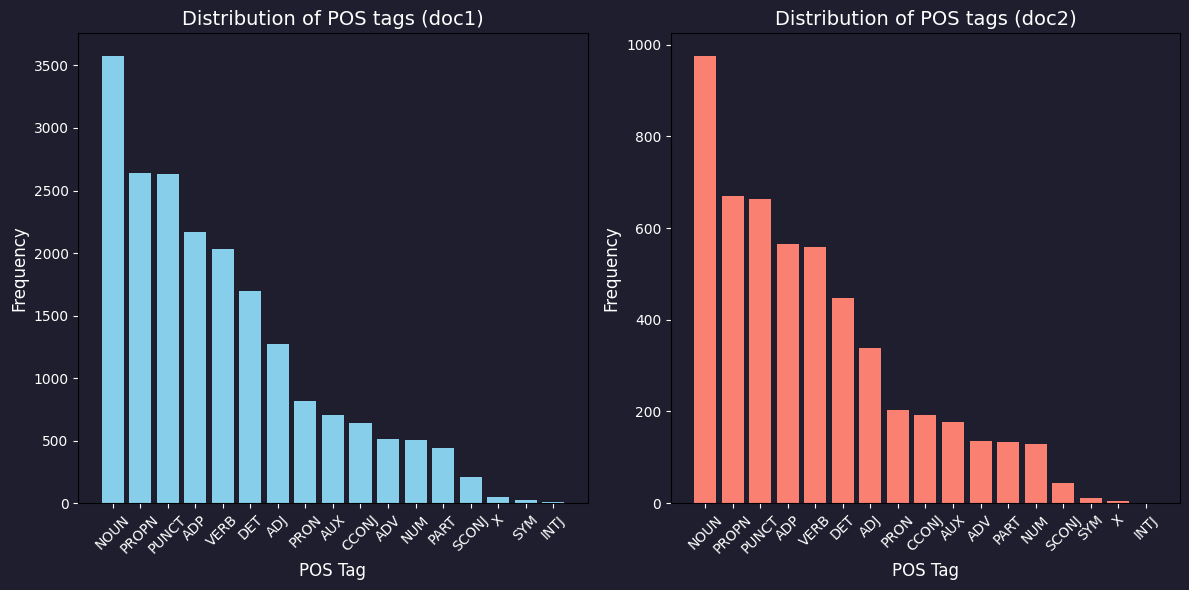

In [ ]:
import os
import matplotlib.pyplot as plt

save_dir = '/content/drive/MyDrive/Colab Notebooks/BERT TRIAL 2/plots'
os.makedirs(save_dir, exist_ok=True)

pos_counts_1 = df1['POS'].value_counts()
pos_counts_2 = df2['POS'].value_counts()

fig, axes = plt.subplots(1, 2, figsize=(12, 6), facecolor='#1E1E2F')

axes[0].bar(pos_counts_1.index, pos_counts_1.values, color='skyblue')
axes[0].set_title('Distribution of POS tags (doc1)', fontsize=14, color='white')
axes[0].set_xlabel('POS Tag', fontsize=12, color='white')
axes[0].set_ylabel('Frequency', fontsize=12, color='white')
axes[0].tick_params(axis='x', rotation=45, colors='white')
axes[0].tick_params(axis='y', colors='white')
axes[0].set_facecolor('#1E1E2F')

axes[1].bar(pos_counts_2.index, pos_counts_2.values, color='salmon')
axes[1].set_title('Distribution of POS tags (doc2)', fontsize=14, color='white')
axes[1].set_xlabel('POS Tag', fontsize=12, color='white')
axes[1].set_ylabel('Frequency', fontsize=12, color='white')
axes[1].tick_params(axis='x', rotation=45, colors='white')
axes[1].tick_params(axis='y', colors='white')
axes[1].set_facecolor('#1E1E2F')

fig.patch.set_facecolor('#1E1E2F')

plt.tight_layout()

plot_path = os.path.join(save_dir, 'pos_distribution.png')
plt.savefig(plot_path, facecolor=fig.get_facecolor())

print(f"Grafico salvato in: {plot_path}")


The distributions of dependencies of both documents is now displayed in the two plots below. The dependencies are found through Spacy.  
Displaying the distribution of dependency labels (e.g., nsubj for subjects, dobj for direct objects, advmod for adverbial modifiers) provides a deeper understanding of syntactic structures. It can be useful for several reasons:

* Understanding Sentence Structure: it helps analyze how different syntactic components (subjects, objects, modifiers, etc.) are distributed, providing insight into the document's linguistic complexity.

* Comparing Text Datasets: dependency distributions can reveal stylistic differences.

* Detecting Anomalies: unusual dependency distributions might indicate parsing errors, inconsistent formatting, or anomalies in the text.

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Grafico salvato in: /content/drive/MyDrive/Colab Notebooks/BERT TRIAL 2/plots/dep_distribution.png


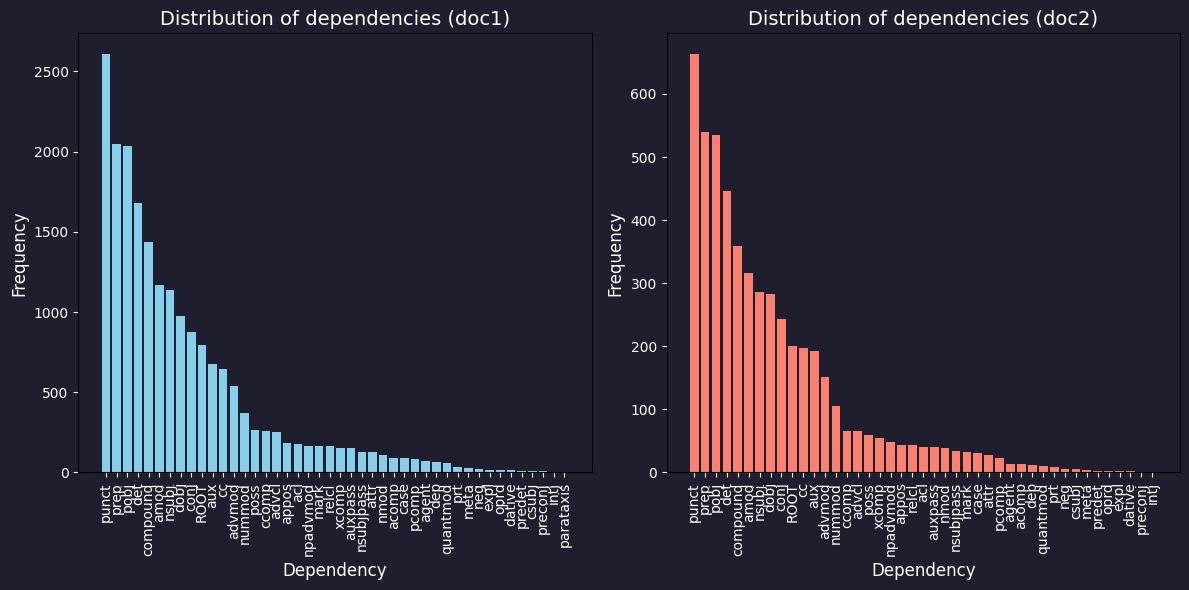

In [ ]:
dep_counts_1 = df1['DEP'].value_counts()
dep_counts_2 = df2['DEP'].value_counts()


fig, axes = plt.subplots(1, 2, figsize=(12, 6), facecolor='#1E1E2F')


axes[0].bar(dep_counts_1.index, dep_counts_1.values, color='skyblue')
axes[0].set_title('Distribution of dependencies (doc1)', fontsize=14, color='white')
axes[0].set_xlabel('Dependency', fontsize=12, color='white')
axes[0].set_ylabel('Frequency', fontsize=12, color='white')
axes[0].tick_params(axis='x', rotation=90, colors='white')
axes[0].tick_params(axis='y', colors='white')
axes[0].set_facecolor('#1E1E2F')


axes[1].bar(dep_counts_2.index, dep_counts_2.values, color='salmon')
axes[1].set_title('Distribution of dependencies (doc2)', fontsize=14, color='white')
axes[1].set_xlabel('Dependency', fontsize=12, color='white')
axes[1].set_ylabel('Frequency', fontsize=12, color='white')
axes[1].tick_params(axis='x', rotation=90, colors='white')
axes[1].tick_params(axis='y', colors='white')
axes[1].set_facecolor('#1E1E2F')


fig.patch.set_facecolor('#1E1E2F')

plt.tight_layout()


plot_path = os.path.join(save_dir, 'dep_distribution.png')
plt.savefig(plot_path, facecolor=fig.get_facecolor())

print(f"Grafico salvato in: {plot_path}")


In both documents, the most frequent dependencies are:
* punctuation
* prepositions
* pobj (Object of a preposition)
* det (determiner)
* compound (Compound words)
* amod (Adjectival modifier)
* nsubj (Nominal subject)
* dobj (Direct object)
* conj (Conjunct)

This result indicates that both documents share a similar syntactic structure, with the most frequent dependencies reflecting common sentence components.

The high occurrence of punctuation suggests well-structured texts, while the frequent use of prepositions and their objects indicates a reliance on prepositional phrases, often found in descriptive or explanatory writing.  

A high count of adjectival modifiers (amod) reinforces this descriptive quality.
The prevalence of nominal subjects and direct objects highlights a strong subject-verb-object (SVO) structure, typical of clear and direct writing.
Finally, common conjuncts (conj) suggest frequent use of coordinated phrases or lists, which can indicate either a complex sentence structure or an enumerative writing style.

DISPLAYING AND PLOTTING ENTITIES (SPACY)

Displaying the distribution of the entities in the two documents provides insights into the prevalence and patterns of key entities such as persons, locations, and organizations. This analysis may help to refine NER models by identifying biases, improving accuracy, and detecting anomalies or errors in entity recognition. Additionally, it enhances text summarization by highlighting essential topics and themes.  
To improve readability, the 'O' tag has been excliuded, since it is disproportionally more frequent than all the other tags.

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Grafico salvato in: /content/drive/MyDrive/Colab Notebooks/BERT TRIAL 2/plots/entity_distribution.png


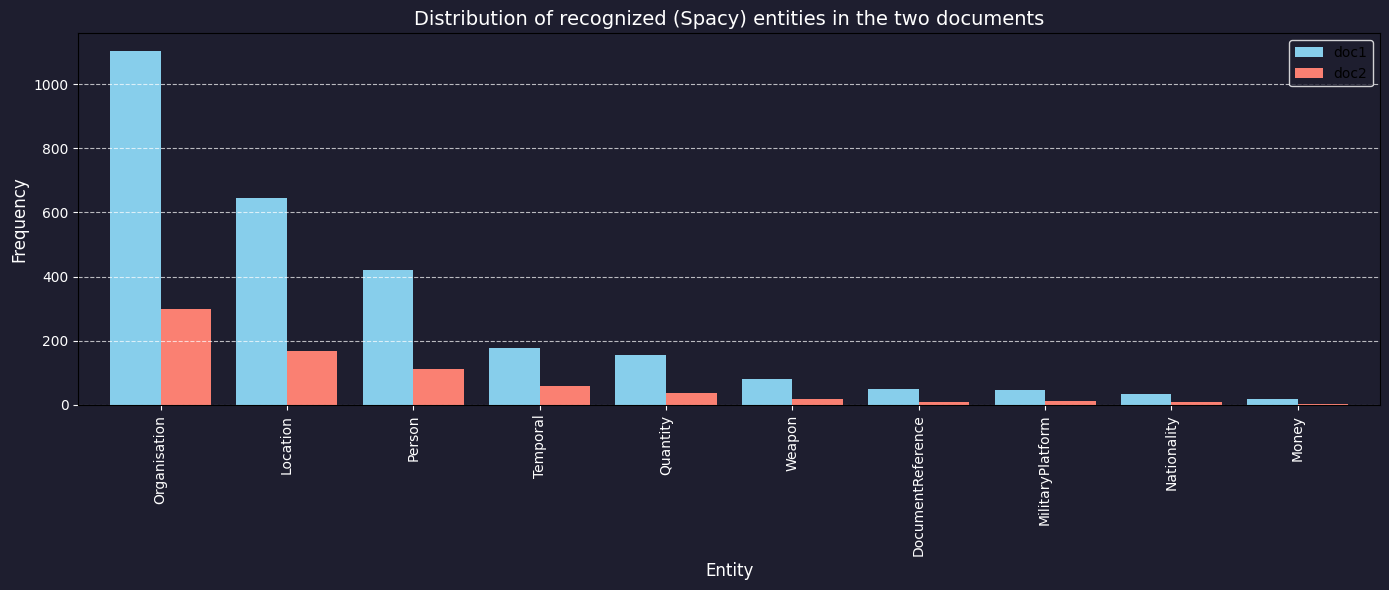

In [ ]:
import os
import matplotlib.pyplot as plt
import pandas as pd

def get_entity_labels(doc):
    return [ent.label_ for ent in doc.ents]

labels_doc1 = get_entity_labels(doc1)
labels_doc2 = get_entity_labels(doc2)

entity_counts_doc1 = pd.Series(labels_doc1).value_counts()
entity_counts_doc2 = pd.Series(labels_doc2).value_counts()

all_labels = sorted(set(entity_counts_doc1.index).union(set(entity_counts_doc2.index)))

entity_df = pd.DataFrame(index=all_labels)
entity_df['doc1'] = entity_counts_doc1
entity_df['doc2'] = entity_counts_doc2
entity_df = entity_df.fillna(0)


entity_df = entity_df.sort_values(by=['doc1', 'doc2'], ascending=False)


save_dir = '/content/drive/MyDrive/Colab Notebooks/BERT TRIAL 2/plots'
os.makedirs(save_dir, exist_ok=True)


fig, ax = plt.subplots(figsize=(14, 6), facecolor='#1E1E2F')
entity_df.plot(kind='bar', ax=ax, color=['skyblue', 'salmon'], width=0.8)

ax.set_title('Distribution of recognized (Spacy) entities in the two documents', fontsize=14, color='white')
ax.set_xlabel('Entity', fontsize=12, color='white')
ax.set_ylabel('Frequency', fontsize=12, color='white')
ax.tick_params(axis='x', rotation=90, colors='white')
ax.tick_params(axis='y', colors='white')
ax.legend(["doc1", "doc2"], facecolor='#1E1E2F', edgecolor='white')
ax.grid(axis="y", linestyle="--", alpha=0.7, color='white')
ax.set_facecolor('#1E1E2F')


fig.patch.set_facecolor('#1E1E2F')

plt.tight_layout()


plot_path = os.path.join(save_dir, 'entity_distribution.png')
plt.savefig(plot_path, facecolor=fig.get_facecolor())

print(f"Grafico salvato in: {plot_path}")


Once again, the two documents display a similaraty in their content. The most frequent tags contain information about locations, organizations and people. Additionally, since the two texts are related to defence topics, tags associated with weapons and military platforms are also present.

DISPLAYING IOB TAGS FREQUENCIES FOR THE TWO DATAFRAMES

As previously mentioned, the most frequent tag, 'O,' was initially excluded from the plot. However, the following visualization now includes its frequency alongside the other IOB tags.  

A clear class imbalance is evident, which could pose challenges during training. To address this, weighted adjustments were applied during the training phase to enhance the model's sensitivity and specificity in classification.

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Grafico salvato in: /content/drive/MyDrive/Colab Notebooks/BERT TRIAL 2/plots/iob_distribution.png


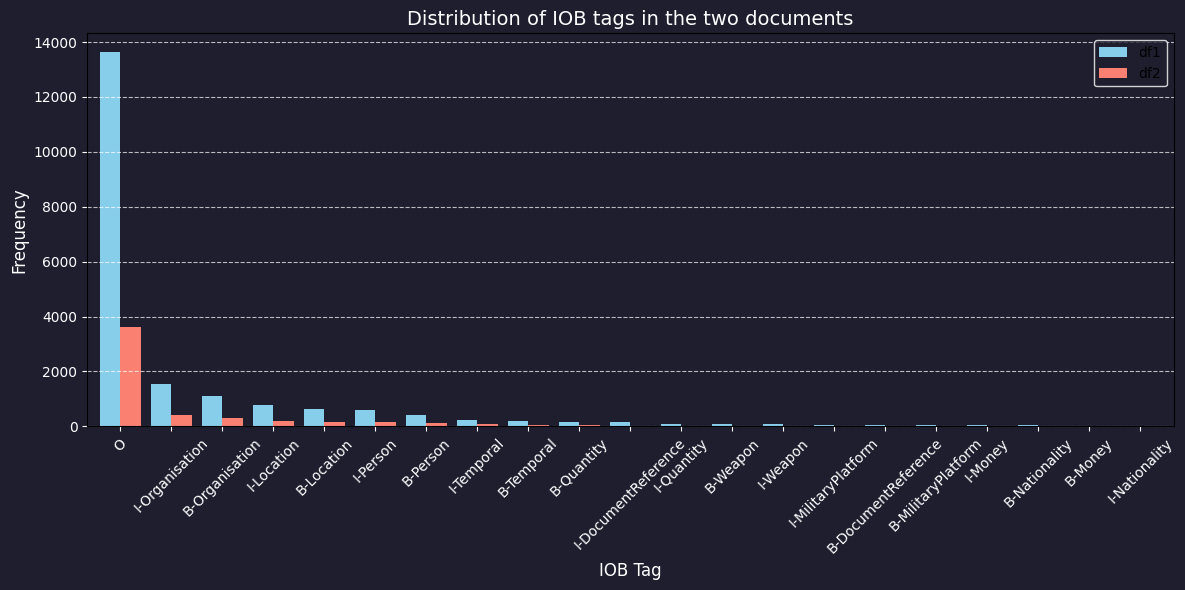

In [ ]:
iob_counts_df1 = df1['tag'].value_counts()
iob_counts_df2 = df2['tag'].value_counts()

all_tags = sorted(set(iob_counts_df1.index).union(set(iob_counts_df2.index)))

iob_df = pd.DataFrame(index=all_tags)
iob_df['df1'] = iob_counts_df1
iob_df['df2'] = iob_counts_df2
iob_df = iob_df.fillna(0)


iob_df = iob_df.sort_values(by=['df1', 'df2'], ascending=False)


save_dir = '/content/drive/MyDrive/Colab Notebooks/BERT TRIAL 2/plots'
os.makedirs(save_dir, exist_ok=True)


fig, ax = plt.subplots(figsize=(12, 6), facecolor='#1E1E2F')
iob_df.plot(kind='bar', ax=ax, color=['skyblue', 'salmon'], width=0.8)

ax.set_title('Distribution of IOB tags in the two documents', fontsize=14, color='white')
ax.set_xlabel('IOB Tag', fontsize=12, color='white')
ax.set_ylabel('Frequency', fontsize=12, color='white')
ax.tick_params(axis='x', rotation=45, colors='white')
ax.tick_params(axis='y', colors='white')
ax.legend(["df1", "df2"], facecolor='#1E1E2F', edgecolor='white')
ax.grid(axis="y", linestyle="--", alpha=0.7, color='white')
ax.set_facecolor('#1E1E2F')


fig.patch.set_facecolor('#1E1E2F')

plt.tight_layout()

plot_path = os.path.join(save_dir, 'iob_distribution.png')
plt.savefig(plot_path, facecolor=fig.get_facecolor())

print(f"Grafico salvato in: {plot_path}")


IMPROVING THE READABILITY OF THE PLOT ESCLUDING O

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Grafico salvato in: /content/drive/MyDrive/Colab Notebooks/BERT TRIAL 2/plots/iob_distribution_no_O.png


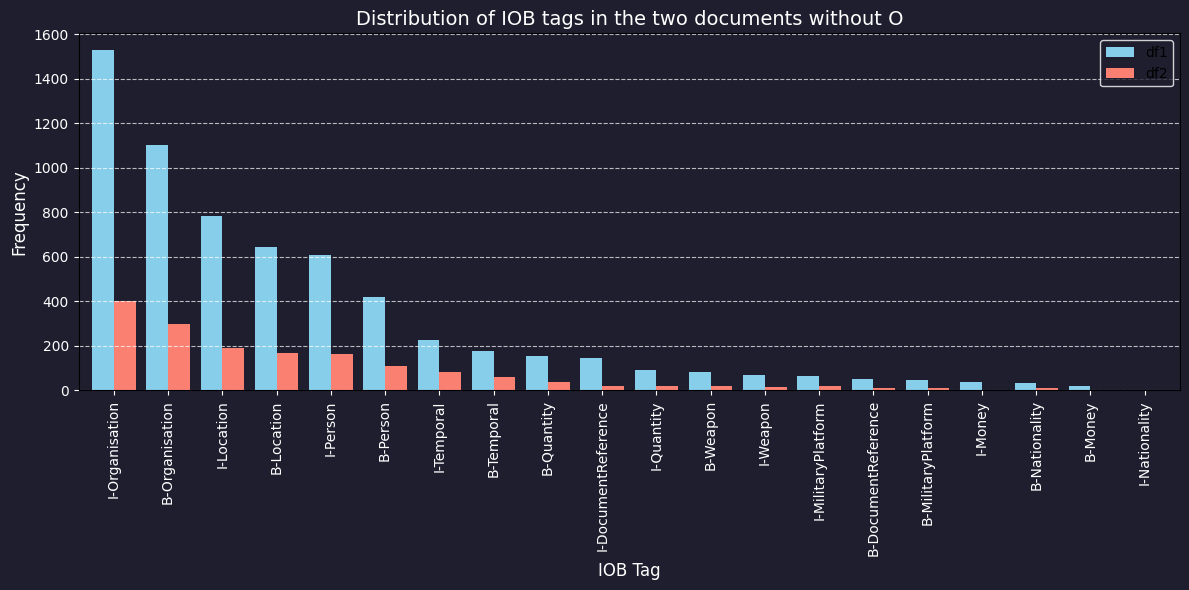

In [ ]:
filtered_df1 = df1[df1['tag'] != 'O']
filtered_df2 = df2[df2['tag'] != 'O']

iob_counts_df1 = filtered_df1['tag'].value_counts()
iob_counts_df2 = filtered_df2['tag'].value_counts()

all_tags = sorted(set(iob_counts_df1.index).union(set(iob_counts_df2.index)))

iob_df_filtered = pd.DataFrame(index=all_tags)
iob_df_filtered['df1'] = iob_counts_df1
iob_df_filtered['df2'] = iob_counts_df2
iob_df_filtered = iob_df_filtered.fillna(0)


iob_df_filtered = iob_df_filtered.sort_values(by=['df1', 'df2'], ascending=False)


save_dir = '/content/drive/MyDrive/Colab Notebooks/BERT TRIAL 2/plots'
os.makedirs(save_dir, exist_ok=True)


fig, ax = plt.subplots(figsize=(12, 6), facecolor='#1E1E2F')
iob_df_filtered.plot(kind='bar', ax=ax, color=['skyblue', 'salmon'], width=0.8)

ax.set_title('Distribution of IOB tags in the two documents without O', fontsize=14, color='white')
ax.set_xlabel('IOB Tag', fontsize=12, color='white')
ax.set_ylabel('Frequency', fontsize=12, color='white')
ax.tick_params(axis='x', rotation=90, colors='white')
ax.tick_params(axis='y', colors='white')
ax.legend(["df1", "df2"], facecolor='#1E1E2F', edgecolor='white')
ax.grid(axis="y", linestyle="--", alpha=0.7, color='white')
ax.set_facecolor('#1E1E2F')

fig.patch.set_facecolor('#1E1E2F')

plt.tight_layout()

plot_path = os.path.join(save_dir, 'iob_distribution_no_O.png')
plt.savefig(plot_path, facecolor=fig.get_facecolor())

print(f"Grafico salvato in: {plot_path}")

BAG OF WORDS AND TERM FREQUENCY ANALYSIS

TF-IDF (Term Frequency-Inverse Document Frequency) is a statistical measure used to evaluate the importance of a word in a document.  It is calculated by multiplying the Term Frequency, which measures how often a word appears in a document, and the Inverse Document Frequency, which reduces the weight of common words across the document (e.g., "the," "and") while emphasizing rare but important terms.  
It can be observed that the greatest part of the top 10 most important words in the two documents are the same, however there some dissimilarities. In the first file, we have the words "Iraqi", "al" and "support", while among the most important words of the second text, we can see "strike", "security" and "operation".  
We may speculate that the first document discusses Iraq and military or hunimanitarian aid more often, while the second might be more related to military operations and attacks.  
As for the words they share, we notice that both documents address topics related to Syria, Iraq and the terrorist organization of the Islamic State of Iraq and the Levant (ISIL), also known as ISIS.

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Grafico salvato in: /content/drive/MyDrive/Colab Notebooks/BERT TRIAL 2/plots/tfidf_top_terms.png


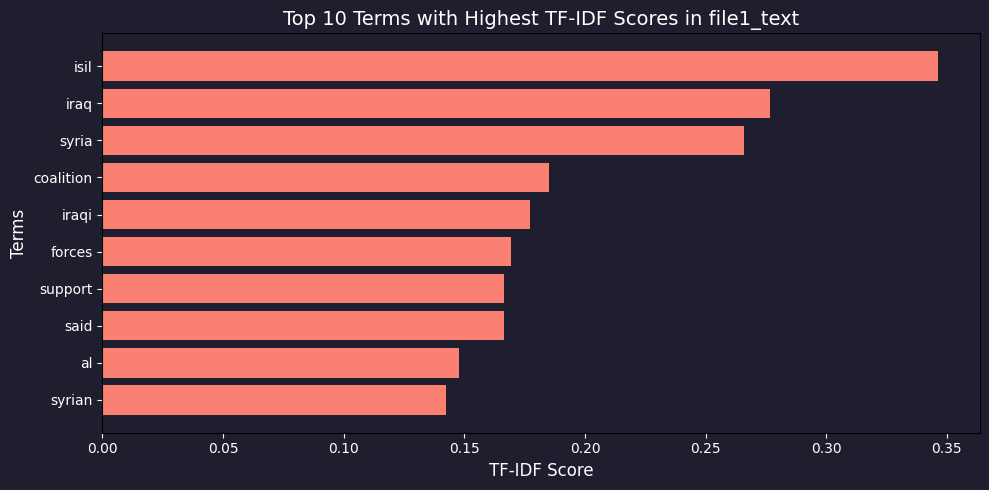

In [ ]:

tf_idf_vec1 = TfidfVectorizer(use_idf=True, ngram_range=(1, 1), stop_words='english')

tf_idf_data1 = tf_idf_vec1.fit_transform([file1_text])

tf_idf_dataframe1 = pd.DataFrame(tf_idf_data1.toarray(), columns=tf_idf_vec1.get_feature_names_out())

tf_idf_values = tf_idf_dataframe1.iloc[0]

top_n = 10
top_terms = tf_idf_values.sort_values(ascending=False).head(top_n)

fig, ax = plt.subplots(figsize=(10, 5), facecolor='#1E1E2F')
ax.barh(top_terms.index, top_terms.values, color='salmon')

ax.set_xlabel("TF-IDF Score", fontsize=12, color='white')
ax.set_ylabel("Terms", fontsize=12, color='white')
ax.set_title(f"Top {top_n} Terms with Highest TF-IDF Scores in file1_text", fontsize=14, color='white')
ax.invert_yaxis()
ax.tick_params(axis='x', colors='white')
ax.tick_params(axis='y', colors='white')
ax.set_facecolor('#1E1E2F')


fig.patch.set_facecolor('#1E1E2F')

plt.tight_layout()

tfidf_plot_path = os.path.join(save_dir, 'tfidf_top_terms.png')
plt.savefig(tfidf_plot_path, facecolor=fig.get_facecolor())

print(f"Grafico salvato in: {tfidf_plot_path}")


/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Grafico salvato in: /content/drive/MyDrive/Colab Notebooks/BERT TRIAL 2/plots/tfidf_top_terms_file2.png


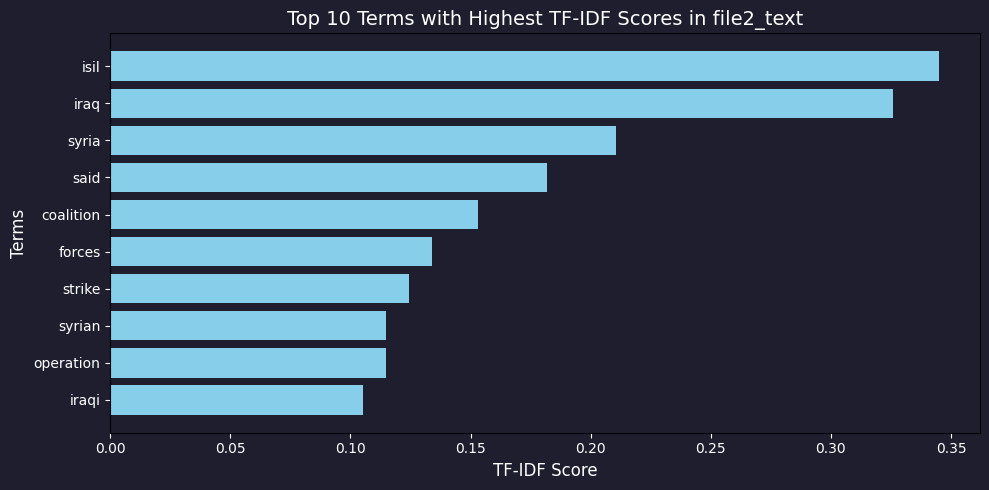

In [ ]:
tf_idf_vec2 = TfidfVectorizer(use_idf=True, ngram_range=(1, 1), stop_words='english')

tf_idf_data2 = tf_idf_vec2.fit_transform([file2_text])

tf_idf_dataframe2 = pd.DataFrame(tf_idf_data2.toarray(), columns=tf_idf_vec2.get_feature_names_out())

tf_idf_values2 = tf_idf_dataframe2.iloc[0]

top_n = 10
top_terms2 = tf_idf_values2.sort_values(ascending=False).head(top_n)

fig, ax = plt.subplots(figsize=(10, 5), facecolor='#1E1E2F')
ax.barh(top_terms2.index, top_terms2.values, color='skyblue')

ax.set_xlabel("TF-IDF Score", fontsize=12, color='white')
ax.set_ylabel("Terms", fontsize=12, color='white')
ax.set_title(f"Top {top_n} Terms with Highest TF-IDF Scores in file2_text", fontsize=14, color='white')
ax.invert_yaxis()
ax.tick_params(axis='x', colors='white')
ax.tick_params(axis='y', colors='white')
ax.set_facecolor('#1E1E2F')


fig.patch.set_facecolor('#1E1E2F')

plt.tight_layout()


tfidf_plot_path2 = os.path.join(save_dir, 'tfidf_top_terms_file2.png')
plt.savefig(tfidf_plot_path2, facecolor=fig.get_facecolor())

print(f"Grafico salvato in: {tfidf_plot_path2}")


LATENT DIRICHLET ALLOCATION (LDA)

Finally, LDA is performed on both documents to identify the hidden topics within. LDA assumes that each document is a mixture of multiple topics, and each topic is a distribution of words. It works by analyzing word co-occurrence patterns and assigning probabilities to words belonging to different topics.

First, CountVectorizer is used to convert text into a sparse matrix (document-term matrix) where rows represent documents and columns represent words. Both extremely rare and very common words are excluded from the analysis.

In [ ]:


cv = CountVectorizer(max_df=0.95, min_df=0.0001, stop_words='english')

dtm = cv.fit_transform(df1['token'])

dtm

<19930x1415 sparse matrix of type '<class 'numpy.int64'>'
	with 7752 stored elements in Compressed Sparse Row format>

The LDA model is initialized to find 3 topics in the first document, then it is trained using the document-term matrix that was previously defined.  
Finally, the top fifteen words for each of the four topics are printed below.

In [ ]:
LDA = LatentDirichletAllocation(n_components=3, random_state=42)
LDA.fit(dtm)

for index, topic in enumerate(LDA.components_):
    print(f'THE TOP 15 WORDS FOR TOPIC #{index}')
    print([cv.get_feature_names_out()[i] for i in topic.argsort()[-15:]])
    print('\n')

THE TOP 15 WORDS FOR TOPIC #0
['campaign', 'tobias', 'regime', 'ellwood', 'tactical', 'international', 'strikes', 'foreign', 'mosul', 'united', 'security', 'syrian', 'said', 'forces', 'iraq']


THE TOP 15 WORDS FOR TOPIC #1
['today', 'destroyed', 'states', 'work', 'near', 'city', 'killed', 'strike', 'operation', 'government', 'minister', 'al', 'support', 'iraqi', 'isil']


THE TOP 15 WORDS FOR TOPIC #2
['daesh', 'uk', 'continue', 'humanitarian', 'conducted', 'defeat', 'state', 'operations', 'military', 'attack', 'group', 'secretary', 'people', 'coalition', 'syria']




* **Topic #0** seems to focus on military campaigns and foreign interventions, with words like campaign, regime, tactical, strikes, security, Syrian, forces, and Iraq. The presence of Tobias Ellwood (a British politician) and the word 'international' suggest a possible UK government or international policy perspective.

* **Topic #1** appears to emphasize specific military actions and their consequences, with words such as destroyed, strike, operation, killed, government, minister, Iraqi, and ISIL. This suggests coverage of direct military engagements, casualties, and government responses.

* **Topic #2** centers on broader strategic efforts and international involvement against Daesh (ISIS). Words like daesh, humanitarian, defeat, operations, coalition, military, secretary, and Syria indicate discussions on counter-terrorism, military strategy, and international coordination.

Topic modeling visualization is made possible using the pyLDAvis library, which helps in understanding the similarity between topics, the proportion of each topic within the text, and the frequency with which each topic generates specific terms.  
The three topics found, represented by the bubbles, are far apart from each other, indicating that they are quite distinct. Additionally, the bubbles are large, suggesting that a significant percentage of sentences in the document contributes to each topic.  
On the right, the most common words in the text are displayed along with their overall frequency (in blue) and their estimated frequency within a selected topic (in red).
It can be observed that, for each topic, the frequency of words used in the context of that topic closely aligns with their overall frequency in the text.

In [ ]:
pyLDAvis.enable_notebook()
panel = pyLDAvis.lda_model.prepare(LDA, dtm, cv)
pyLDAvis.display(panel)
save_path = "/content/drive/MyDrive/Colab Notebooks/BERT TRIAL 2/plots/lda_visualization.html"


pyLDAvis.save_html(panel, save_path)


The same procedure is followed for the second document.

In [ ]:
cv = CountVectorizer(max_df=0.95, min_df=0.0001, stop_words='english')
dtm = cv.fit_transform(df2['token'])

dtm

LDA = LatentDirichletAllocation(n_components=3, random_state=42)
LDA.fit(dtm)

for index, topic in enumerate(LDA.components_):
    print(f'THE TOP 15 WORDS FOR TOPIC #{index}')
    print([cv.get_feature_names_out()[i] for i in topic.argsort()[-15:]])
    print('\n')

THE TOP 15 WORDS FOR TOPIC #0
['fight', 'ellwood', 'uk', 'work', 'states', 'air', 'near', 'military', 'minister', 'secretary', 'state', 'iraqi', 'security', 'syrian', 'isil']


THE TOP 15 WORDS FOR TOPIC #1
['2016', 'operations', 'use', 'united', 'including', 'al', 'government', 'people', 'foreign', 'aircraft', 'regime', 'support', 'said', 'syria', 'iraq']


THE TOP 15 WORDS FOR TOPIC #2
['islamic', 'time', 'civilians', '10', 'fighters', 'today', 'attack', 'counter', 'strikes', 'international', 'group', 'operation', 'strike', 'forces', 'coalition']




* **Topic #0** emphasizes the role of the UK and international leaders in military actions. Words like Ellwood, UK, minister, secretary, states, security, Syrian, ISIL suggest discussions around government involvement, policy decisions, and military engagement in conflict zones.

* **Topic #1** seems to cover military operations and foreign involvement, with terms like operations, foreign, aircraft, regime, Syria, Iraq, government, and support. The presence of 2016 may indicate a focus on specific events or policies from that time period.

* **Topic #2** highlights military strikes, counterterrorism, and civilian impact. Words like Islamic, civilians, attack, counter, strikes, international, group, operation, coalition, and forces suggest coverage of both military actions and their humanitarian consequences.

In [ ]:
panel2 = pyLDAvis.lda_model.prepare(LDA, dtm, cv)
pyLDAvis.display(panel2)
save_path = "/content/drive/MyDrive/Colab Notebooks/BERT TRIAL 2/plots/lda_visualization2.html"


pyLDAvis.save_html(panel2, save_path)

In [ ]:
%reset -f


# 2) LSTM MODEL

In [ ]:
# DF
import pandas as pd
import spacy
nlp = spacy.load('en_core_web_sm')
from spacy.tokens import Doc, Span
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D, Input, concatenate, Masking
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.preprocessing import LabelEncoder
import urllib.request
import zipfile
import os
from collections import Counter
from sklearn.utils.class_weight import compute_class_weight
import tensorflow as tf
from google.colab import drive
drive.mount('/content/drive')

drive_path = '/content/drive/MyDrive/Colab Notebooks/BERT TRIAL 2'
file_path = os.path.join(drive_path, 'file1.ann')
file_path2 = os.path.join(drive_path, 'file2.ann')

def create_dataframe(content):
    with open(content, 'r', encoding='utf-8') as file:
        lines = file.readlines()
    data = [line.split() for line in lines]
    df = pd.DataFrame(data, columns=['token', 'tag'])
    df = df.drop(index=df.index[0])  # Drop the header or first line if it's not data.
    return df

df_file1 = create_dataframe(file_path)
df_file2 = create_dataframe(file_path2)

df_file1 = pd.concat([df_file1, df_file2], ignore_index=True)

def pulisci_df(df):
    def is_arabic(word):
        if word is None or pd.isnull(word):  # Check for None or NaN
            return True
        word = str(word)
        #remove_chars = "\n" + string.punctuation  + "\”" + "\“" + "\’" + "“”‘’–—…«»‹›"
        #if word in remove_chars:
            #return True
        return any('\u0600' <= char <= '\u06FF' for char in word)

    mask = df['token'].apply(is_arabic)
    return df[~mask]  # Keep rows where the condition is False

df_file1 = pulisci_df(df_file1)
df_file1 = df_file1.reset_index(drop=True)

print(df_file1.head())

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
       token tag
0  Operation   O
1      Steel   O
2    Curtain   O
3          (   O
4     Arabic   O


In [ ]:
#CREATE A SPACY DOC FILE

def pulisci_file(df, column_name):
    result = df[column_name].str.cat(sep=' ')
    return result

file1_text = pulisci_file(df_file1, 'token')

doc1 = nlp(file1_text)

In [ ]:
# CHANGE SPACY'S TAGGING SYSTEM TO IOB2 (ORIGINAL FORMAT OF THE DATASET)

from spacy.training import align

original_tokens = df_file1["token"].tolist()
spacy_tokens = [token.text for token in doc1]

alignments = align.get_alignments(original_tokens, spacy_tokens)

aligned_iob2 = ["O"] * len(spacy_tokens)

for original_idx, spacy_indices in enumerate(alignments[0]):
    tag = df_file1["tag"][original_idx]
    if len(spacy_indices) == 1:
        aligned_iob2[spacy_indices[0]] = tag
    else:
        for idx in spacy_indices:
            aligned_iob2[idx] = tag

df_test = pd.DataFrame({'tokens': spacy_tokens, 'tag': aligned_iob2})

In [ ]:
# REPLACE DOC1 TAGS WITH THE ORIGINAL IOB2 TAGS

def extract_entities(df, tag_column="tag"):
    entities = []
    current_entity = None

    for index, row in df.iterrows():
        tag = row[tag_column]

        if tag.startswith("B-"):  # Begin a new entity
            if current_entity:  # Save the previous entity
                entities.append(current_entity)
            entity_type = tag[2:]  # Extract the entity type
            current_entity = {"type": entity_type, "start": index, "end": index + 1}

        elif tag.startswith("I-") and current_entity:  # Inside an entity
            entity_type = tag[2:]
            if current_entity["type"] == entity_type:  # Ensure it's the same entity type
                current_entity["end"] = index + 1  # Extend the current entity

        else:  # Outside any entity
            if current_entity:  # Save the current entity
                entities.append(current_entity)
                current_entity = None

    # Add the last entity if it exists
    if current_entity:
        entities.append(current_entity)

    return entities

# Extract entities
custom_entities = extract_entities(df_test)

doc1.ents = [Span(doc1, entity["start"], entity["end"], label=entity["type"]) for entity in custom_entities]
doc1.set_ents(doc1.ents, default="outside")

In [ ]:
data = []
for token in doc1:
    data.append([
        getattr(token, "text"),      # Token text
        getattr(token, "lemma_", None),   # Lemma
        getattr(token, "pos_", None),     # Part-of-speech tag
        getattr(token, "dep_", None),     # Dependency label
        getattr(token.head, "text", None),# Head text
        f"{token.ent_iob_}-{token.ent_type_}" if token.ent_type_ else "O"
    ])

def join_and_clear(df, col_name, row1, row2):
    df.at[row1, col_name] = f"{df.at[row1, col_name]} {df.at[row2, col_name]}"
    df.loc[row2] = [None] * len(df.columns)

df = pd.DataFrame(data, columns=["token", "Lemma", "POS", "DEP", "Head", "tag"])

In [ ]:
data = []

for sent in doc1.sents:
    sentence_text = sent.text
    iob_tags = []
    for token in sent:
        if token.ent_iob_ == "O":
            iob_tags.append(token.ent_iob_)
        else:
            iob_tags.append(token.ent_iob_ + "-" + token.ent_type_)
    iob_tags_str = ' '.join(iob_tags)
    data.append({"sentence": sentence_text, "IOB_tag": iob_tags_str})

df1 = pd.DataFrame(data)

The following Python code is used for **data tokenization**, a key preprocessing step in Natural Language Processing (NLP) tasks. Tokenization converts text into numerical representations that can be processed by machine learning models.

In [ ]:
#DATA TOKENIZATION

tokenizer = Tokenizer()
tokenizer.fit_on_texts(df1['sentence'].values)
sequences = tokenizer.texts_to_sequences(df1['sentence'].values)

IOB_tags = df['tag'].unique()

# Map each tag to an integer
tag_encoder = LabelEncoder()
tag_encoder.fit(IOB_tags)
tag_to_int = {tag: idx for idx, tag in enumerate(tag_encoder.classes_)}

df1['IOB_tag_sequences'] = [[tag_to_int[tag] for tag in seq.split()] for seq in df1['IOB_tag']]

vocabulary_size_sentence = len(tokenizer.word_counts)
print(vocabulary_size_sentence)
print(IOB_tags)

3902
['O' 'B-Organisation' 'I-Organisation' 'B-Temporal' 'I-Temporal'
 'B-Nationality' 'B-Location' 'I-Location' 'B-Person' 'I-Person'
 'B-DocumentReference' 'I-DocumentReference' 'B-Money' 'I-Money'
 'B-Quantity' 'B-MilitaryPlatform' 'I-MilitaryPlatform' 'B-Weapon'
 'I-Weapon' 'I-Quantity' 'I-Nationality']


In [ ]:
#DOWNLOAD THE TRAINED TOKENIZER FOR THE DASHBOARD

import pickle

with open("tokenizer1.pkl", "wb") as f:
    pickle.dump(tokenizer, f)

In [ ]:
#PADDING ONE HOT ENCODED LABELS FOR FOCAL CROSSENTROPY LOSS

from tensorflow.keras.utils import to_categorical

num_tags = len(tag_to_int)  # Total number of tags
Y_padded = pad_sequences(df1['IOB_tag_sequences'], maxlen=73, value=tag_to_int['O'], padding='post')
df1['IOB_tag_one_hot'] = [to_categorical(seq, num_classes=num_tags) for seq in Y_padded]

The following Python code is used for **padding sequences**. Padding ensures that all input sequences are of the same length, allowing them to be processed efficiently by the models. Since the longest sentence of the dataset is composed of 73 tokens, we set this value to determine the padding length.

In [ ]:
#PADDING

sequence_len = np.array([len(s) for s in sequences])
longest_sequence = sequence_len.max() #73 tokens in the longest sequence

print([(str(p) + '%', np.percentile(sequence_len, p)) for p in range(75,101, 5)])
max_sequence_len = 73

X = pad_sequences(sequences, maxlen=max_sequence_len, padding='post')

Y_iob = pad_sequences(df1['IOB_tag_sequences'], maxlen=max_sequence_len, value = tag_to_int['O'], padding='post')
#Y_iob = pad_sequences(df1['IOB_tag_one_hot'], maxlen=max_sequence_len, value = to_categorical(tag_to_int['O'], num_classes=num_tags), padding='post')
#USE IOB_tag_sequences FOR CATEGORIES INSTEAD OF ONE HOT ENCODINGS

tokenizer.index_word[0] = '_PAD_'

[('75%', 29.0), ('80%', 32.0), ('85%', 35.0), ('90%', 39.0), ('95%', 44.0), ('100%', 73.0)]


The data is split for training and evaluation by creating separate datasets. The training set is used to teach the model, while the testing set assesses the model's performance on unseen data, helping to identify overfitting or underfitting issues.

In [ ]:
#TEST AND TRAIN SPLIT
indices = np.arange(len(df1['sentence']))
X_train_sentences, temp_sentences, Y_train_IOB, temp_tags, train_indices, temp_indices = train_test_split(
     X, Y_iob, indices, test_size=0.3, random_state=42)

X_val_sentences, X_test_sentences, Y_val_IOB, Y_test_IOB, val_indices, test_indices = train_test_split(
    temp_sentences, temp_tags, temp_indices, test_size=0.3333, random_state=42)

print(X_train_sentences.shape, Y_train_IOB.shape)
print(X_test_sentences.shape, Y_test_IOB.shape)
print(X_val_sentences.shape, Y_val_IOB.shape)

(696, 73) (696, 73)
(100, 73) (100, 73)
(199, 73) (199, 73)


Pre-trained GloVe (Global Vectors for Word Representation) embeddings are loaded to construct an embedding matrix.  
The GloVe embedding matrix serves as a mapping mechanism that converts words into dense, continuous vectors that capture semantic and syntactic properties. These embeddings are derived from extensive corpora, enabling the representation of words based on their contextual usage in large-scale text data.

The GloVe embedding matrix plays a crucial role in improving model performance for the following reasons:

* **Semantic Feature Representation**: The embeddings capture the semantic relationships between words. For instance, entities such as "Paris," "London," and "Berlin" will have similar vector representations due to their contextual similarities, aiding the model in recognizing them as geographic locations.

* **Dimensionality Reduction**:
GloVe embeddings offer dense representations that are both computationally efficient and rich in semantic information.

* **Enhanced Generalization**:
Pre-trained embeddings allow the model to generalize better to unseen data. Even if specific entities are absent from the training dataset, the model can infer their entity type based on their similarity to known words within the embedding space.

In [ ]:
import os
import numpy as np
def load_glove_embedding_matrix(word_index, embed_dim):
    """Load Glove embeddings.

    """
    !wget http://nlp.stanford.edu/data/glove.6B.zip
    !unzip glove*.zip

    path = 'glove.6B.100d.txt'

    embeddings_index = {}
    with open(path, encoding='utf-8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs

    print('Found %s word vectors.' % len(embeddings_index))
    embedding_matrix = np.zeros((len(word_index) + 1, embed_dim))
    for word, i in word_index.items():
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            # words not found in embedding index will be all-zeros.
            embedding_matrix[i] = embedding_vector

    return embedding_matrix


In [ ]:
USE_GLOVE=True
glove_matrix=None
if USE_GLOVE:
    embedding_dim = 100
    glove_matrix = load_glove_embedding_matrix(tokenizer.word_index, embedding_dim)

--2025-02-28 14:22:15--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2025-02-28 14:22:15--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2025-02-28 14:22:15--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glov

Class and sample weights are calculated to mitigate the impact of class imbalance in the IOB tag sequences, which can cause the model to favor more frequent tags and overlook rare ones. By flattening all IOB tags, balanced class weights are computed using `compute_class_weight`, assigning higher weights to less frequent tags to ensure they contribute more significantly during training. These weights are organized in a dictionary for easy access. Since one-hot encoding isn’t used, sample weights are directly computed from the integer-encoded IOB tags (`Y_train_IOB`). This helps the model pay more attention to underrepresented classes, improving its ability to recognize rare tags effectively.

In [ ]:
train_tags = df1["IOB_tag_sequences"].iloc[train_indices]

In [ ]:
#WEIGHTS
from sklearn.utils.class_weight import compute_class_weight
from sklearn.utils.class_weight import compute_sample_weight

y_true_flat = [tag for sentence in train_tags for tag in sentence]

class_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(y_true_flat),
    y=y_true_flat)

class_weight_dict = {class_idx: weight for class_idx, weight in zip(np.unique(y_true_flat), class_weights)}

print(class_weight_dict)

{0: 24.095238095238095, 1: 1.4979277679100058, 2: 16.21794871794872, 3: 56.22222222222222, 4: 25.555555555555557, 5: 0.8424908424908425, 6: 2.219298245614035, 7: 6.588541666666667, 8: 5.897435897435898, 9: 12.777777777777779, 10: 8.187702265372168, 11: 1.1979166666666667, 12: 11.712962962962964, 13: 28.11111111111111, 14: 281.1111111111111, 15: 0.5926446474584212, 16: 1.564625850340136, 17: 10.541666666666666, 18: 4.764595103578155, 19: 13.386243386243386, 20: 0.0696969696969697}


To prevent extreme weight values from negatively impacting model training, a minimum weight of 0.5 is set to avoid underweighting rare classes, while a maximum weight of 5 limits the influence of overly frequent classes. The `np.clip` function constrains all class and sample weights within this range, ensuring that no class is given too little or too much importance. This helps maintain balanced learning and model stability, reducing the risk of overfitting or underfitting specific classes.

In [ ]:
min_weight = max(0.5, min(class_weight_dict.values()))  # Prevent too-low weights
max_weight = min(5, max(class_weight_dict.values()))  # Prevent too-high weights

class_weight_dict = {k: np.clip(v, min_weight, max_weight) for k, v in class_weight_dict.items()}

In [ ]:
sample_weights = np.array([compute_sample_weight(class_weight_dict, y) for y in Y_train_IOB])
sample_weights = np.clip(sample_weights, min_weight, max_weight)

An LSTM-based neural network architecture is defined to perform sequence labeling for IOB tag prediction. The model begins with an embedding layer initialized with pre-trained GloVe vectors, set as non-trainable to retain semantic information, and `mask_zero=True` to handle padded tokens. This is followed by a bidirectional LSTM layer with dropout and recurrent dropout to prevent overfitting, configured with `return_sequences=True` to produce output for each token in the sequence. A dense layer with a softmax activation function generates probability distributions over the IOB tags for each token.

The model is compiled using the Adam optimizer and `SparseCategoricalCrossentropy` as the loss function, suitable for integer-encoded labels. Accuracy with masked 'O' tag is used as the evaluation metric.

To enhance training performance, `ModelCheckpoint` saves the best model weights based on validation loss, while `EarlyStopping` monitors validation loss to halt training if no improvement is observed for 8 consecutive epochs, restoring the best weights.

The model is trained on the padded input sequences (`X_train_final`) and their corresponding IOB tags (`Y_train_final`), incorporating sample weights to address class imbalance. Training history, including loss and accuracy for both training and validation sets, is plotted to visualize performance over epochs.

After training, the model predicts IOB tags for the test set (`X_test_sentences`), with the final predictions obtained by selecting the class with the highest probability for each token.

In [ ]:
import tensorflow as tf
import numpy as np
import random
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, Bidirectional
from keras.losses import SparseCategoricalCrossentropy
from keras.callbacks import ModelCheckpoint, EarlyStopping

SEED_VALUE = 42
random.seed(SEED_VALUE)
np.random.seed(SEED_VALUE)
tf.random.set_seed(SEED_VALUE)

embed_dim = 100
lstm_out = 100

o_index = tag_to_int["O"]

def masked_accuracy(y_true, y_pred):
    y_pred_classes = tf.argmax(y_pred, axis=-1)
    y_true_classes = tf.cast(y_true, tf.int64)


    mask = tf.not_equal(y_true_classes, o_index)


    y_true_masked = tf.boolean_mask(y_true_classes, mask)
    y_pred_masked = tf.boolean_mask(y_pred_classes, mask)


    matches = tf.equal(y_true_masked, y_pred_masked)
    accuracy = tf.reduce_mean(tf.cast(matches, tf.float32))

    return accuracy

model = Sequential()
model.add(Embedding(vocabulary_size_sentence+1, embed_dim, weights=[glove_matrix],
                    trainable=False, input_length=X.shape[1], mask_zero=True))
model.add(Bidirectional(LSTM(lstm_out, return_sequences=True, dropout=0.4, recurrent_dropout=0.3)))
model.add(Dense(len(tag_to_int), activation='softmax'))


model.compile(loss=SparseCategoricalCrossentropy(), optimizer='adam', metrics=[masked_accuracy])

print(model.summary())

best_model_file = 'lstm-conll-best-model.weights.h5'

checkpoint = ModelCheckpoint(
    best_model_file,
    save_weights_only=True,
    save_best_only=True
)

early_stopping_callback = EarlyStopping(monitor="val_loss", min_delta=0.008, patience=8, verbose=1, mode="auto",
                                        restore_best_weights=True)

callbacks = [checkpoint, early_stopping_callback]

history = model.fit(x=X_train_sentences, y=Y_train_IOB, sample_weight=sample_weights,
          validation_data=(X_val_sentences, Y_val_IOB),
          epochs=30, verbose=2, batch_size=64, callbacks=callbacks)


model_save_path = "/content/drive/MyDrive/Colab Notebooks/BERT TRIAL 2/lstm_conll_complete_model.h5"

model.save(model_save_path)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ ?                           │         390,300 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 390,300 (1.49 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 390,300 (1.49 MB)

None
Epoch 1/30
11/11 - 14s - 1s/step - loss: 2.4304 - masked_accuracy: 0.0165 - val_loss: 1.4992 - val_masked_accuracy: 0.0000e+00
Epoch 2/30
11/11 - 3s - 312ms/step - loss: 2.1417 - masked_accuracy: 0.0072 - val_loss: 1.5701 - val_masked_accuracy: 0.0218
Epoch 3/30
11/11 - 3s - 302ms/step - loss: 2.0189 - masked_accuracy: 0.0280 - val_loss: 1.4248 - val_masked_accuracy: 0.0338
Epoch 4/30
11/11 - 3s - 313ms/step - loss: 1.9088 - masked_accuracy: 0.0419 - val_loss: 1.3797 - val_masked_accuracy: 0.0742
Epoch 5/30
11/11 - 3s - 310ms/step - loss: 1.7991 - masked_accuracy: 0.0870 - val_loss: 1.3196 - val_masked_accuracy: 0.1237
Epoch 6/30
11/11 - 3s - 285ms/step - loss: 1.6874 - masked_accuracy: 0.1253 - val_loss: 1.2940 - val_masked_accuracy: 0.1662
Epoch 7/30
11/11 - 4s - 322ms/step - loss: 1.6081 - masked_accuracy: 0.1476 - val_loss: 1.2886 - val_masked_accuracy: 0.1869
Epoch 8/30
11/11 - 4s - 328ms/step - loss: 1.5498 - masked_accuracy: 0.1589 - val_loss: 1.2595 - val_masked_accuracy: 

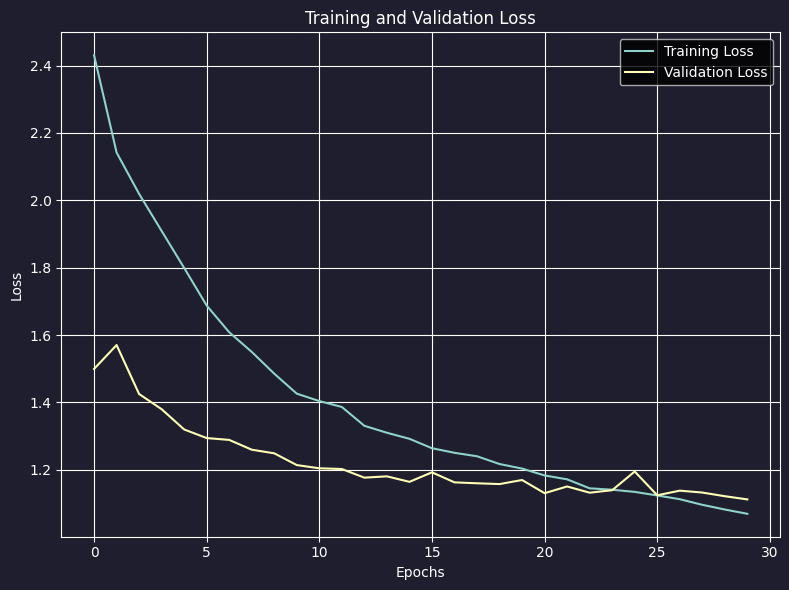

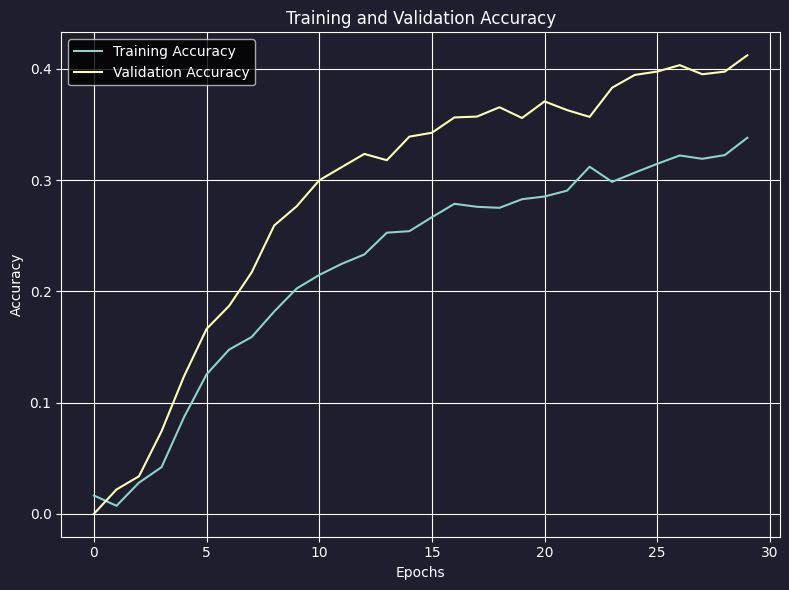

In [ ]:
import os
import matplotlib.pyplot as plt


plt.style.use('dark_background')

if not os.path.exists('plots'):
    os.makedirs("/content/drive/MyDrive/Colab Notebooks/BERT TRIAL 2/plots")

fig_loss, ax_loss = plt.subplots(figsize=(8, 6))
ax_loss.plot(history.history['loss'], label='Training Loss')
ax_loss.plot(history.history['val_loss'], label='Validation Loss')
ax_loss.set_xlabel('Epochs', color='white')
ax_loss.set_ylabel('Loss', color='white')
ax_loss.legend()
ax_loss.set_title('Training and Validation Loss', color='white')
ax_loss.grid(True)

fig_loss.patch.set_facecolor('#1E1E2F')
ax_loss.set_facecolor('#1E1E2F')

ax_loss.grid(True, color='white')

fig_loss.patch.set_edgecolor('white')

fig_loss.savefig('/content/drive/MyDrive/Colab Notebooks/BERT TRIAL 2/plots/training_validation_loss_lstm.png', dpi=300)

plt.tight_layout()
plt.show()

fig_acc, ax_acc = plt.subplots(figsize=(8, 6))

if 'masked_accuracy' in history.history:
    ax_acc.plot(history.history['masked_accuracy'], label='Training Accuracy')
else:
    ax_acc.plot(history.history['accuracy'], label='Training Accuracy')
if 'val_masked_accuracy' in history.history:
    ax_acc.plot(history.history['val_masked_accuracy'], label='Validation Accuracy')
else:
    ax_acc.plot(history.history['val_accuracy'], label='Validation Accuracy')

ax_acc.set_xlabel('Epochs', color='white')
ax_acc.set_ylabel('Accuracy', color='white')
ax_acc.legend()
ax_acc.set_title('Training and Validation Accuracy', color='white')
ax_acc.grid(True)

fig_acc.patch.set_facecolor('#1E1E2F')
ax_acc.set_facecolor('#1E1E2F')

ax_acc.grid(True, color='white')

fig_acc.patch.set_edgecolor('white')

fig_acc.savefig('/content/drive/MyDrive/Colab Notebooks/BERT TRIAL 2/plots/training_validation_accuracy_lstm.png', dpi=300)

plt.tight_layout()
plt.show()


In [ ]:

from sklearn.metrics import accuracy_score, classification_report

prediction_probas = model.predict(X_test_sentences) # Output shape = (num_samples, sequence_length, num_classes)
predictions = np.argmax(prediction_probas, axis=-1)

y_true_flat = [tag for sentence in Y_test_IOB for tag in sentence]
y_pred_flat = [pred for sentence in predictions for pred in sentence]

all_labels = sorted(set(y_true_flat + y_pred_flat))
int_to_tag = {idx: tag for tag, idx in tag_to_int.items()}
label_indices = [int_to_tag[label] for label in all_labels]

report = classification_report(y_true_flat, y_pred_flat, labels=all_labels, target_names=label_indices, output_dict=True)
report_df = pd.DataFrame(report).transpose()
report_df.loc[['accuracy', 'macro avg', 'weighted avg'], 'support'] = None
report_df.to_csv('test_classification_report.csv', index=True)
report_df = report_df.round(2)
print(report_df)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
                     precision  recall  f1-score  support
B-DocumentReference       0.33    0.14      0.20      7.0
B-Location                0.38    0.20      0.26     75.0
B-MilitaryPlatform        0.17    0.17      0.17      6.0
B-Money                   0.00    0.00      0.00      3.0
B-Nationality             0.00    0.00      0.00      1.0
B-Organisation            0.44    0.14      0.21    128.0
B-Person                  0.32    0.39      0.35     51.0
B-Quantity                0.15    0.33      0.21     21.0
B-Temporal                0.26    0.35      0.30     23.0
B-Weapon                  0.13    0.40      0.20      5.0
I-DocumentReference       0.29    0.57      0.38     14.0
I-Location                0.43    0.37      0.40     70.0
I-MilitaryPlatform        0.39    1.00      0.56     12.0
I-Money                   0.18    0.33      0.24      6.0
I-Organisation            0.48    0.36      0.41    192.0
I-Person                  0.51    

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_

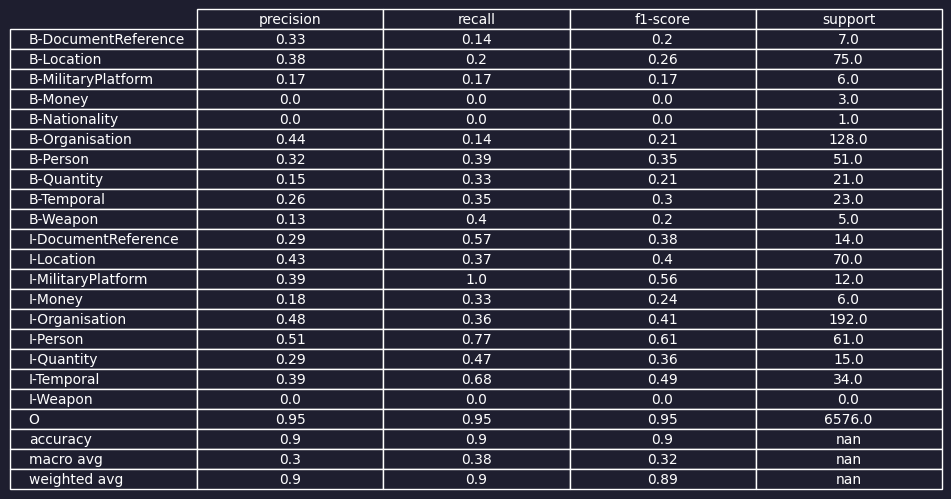

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(8, 6))
fig.patch.set_facecolor('#1E1E2F')
ax.set_facecolor('#1E1E2F')
ax.axis('off')

table = plt.table(cellText=report_df.values,
                  colLabels=report_df.columns,
                  rowLabels=report_df.index,
                  cellLoc='center',
                  loc='center')

table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1.2, 1.2)

for key, cell in table.get_celld().items():
    cell.set_facecolor('#1E1E2F')
    cell.set_edgecolor('white')
    cell.set_text_props(color='white')

plt.savefig('/content/drive/MyDrive/Colab Notebooks/BERT TRIAL 2/plots/report_lstm.png', dpi=300, bbox_inches='tight', pad_inches=0.1, facecolor=fig.get_facecolor())
plt.show()


In [ ]:
results = model.evaluate(X_test_sentences, Y_test_IOB, batch_size=128)
print("test loss: {} ".format(results[0]))
print("test accuracy: {} ".format(results[1]))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - loss: 0.9749 - masked_accuracy: 0.3688
test loss: 0.9749119281768799 
test accuracy: 0.36878451704978943 


Below, different confusion matrices are printed to show the model classification performance.  
It can be observed that the class which the model can predict the most correctly is 'O', but the confusion matrix with percentages also shows that it can classify other classes with some limited accuracy.

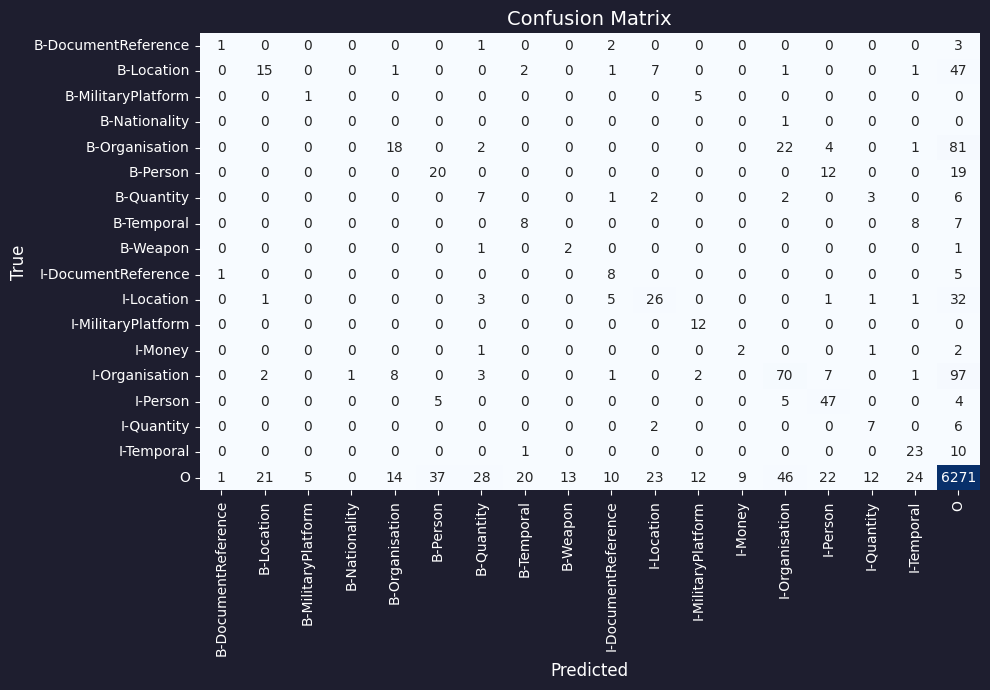

Grafico salvato in: /content/drive/MyDrive/Colab Notebooks/BERT TRIAL 2/plots/confusion_matrix1_lstm.png


In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import os

def plot_custom_confusion_matrix(cm, labels, save_dir):

    plt.figure(figsize=(10, 7), facecolor='#1E1E2F')


    ax = sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels, cbar=False)


    ax.set_xlabel('Predicted', fontsize=12, color='white')
    ax.set_ylabel('True', fontsize=12, color='white')
    ax.set_title('Confusion Matrix', fontsize=14, color='white')


    ax.tick_params(axis='x', colors='white')
    ax.tick_params(axis='y', colors='white')


    ax.set_facecolor('#1E1E2F')
    plt.tight_layout()


    confusion_matrix_plot_path = os.path.join(save_dir, 'confusion_matrix1_lstm.png')
    plt.savefig(confusion_matrix_plot_path, facecolor='#1E1E2F')
    plt.show()

    print(f"Grafico salvato in: {confusion_matrix_plot_path}")

def compute_and_plot_custom_confusion_matrix(y_pred_flat, y_true_flat, int_to_tag, save_dir):

    all_true_labels = []
    all_predictions = []


    for pred, true in zip(y_pred_flat, y_true_flat):


          all_true_labels.append(true)
          all_predictions.append(pred)


    unique_labels = list(set(all_true_labels) & set(all_predictions))


    display_labels = [int_to_tag[label] for label in unique_labels]


    cm = confusion_matrix(all_true_labels, all_predictions, labels=unique_labels)


    plot_custom_confusion_matrix(cm, display_labels, save_dir)

save_dir = '/content/drive/MyDrive/Colab Notebooks/BERT TRIAL 2/plots'
os.makedirs(save_dir, exist_ok=True)

compute_and_plot_custom_confusion_matrix(y_pred_flat, y_true_flat, int_to_tag, save_dir)


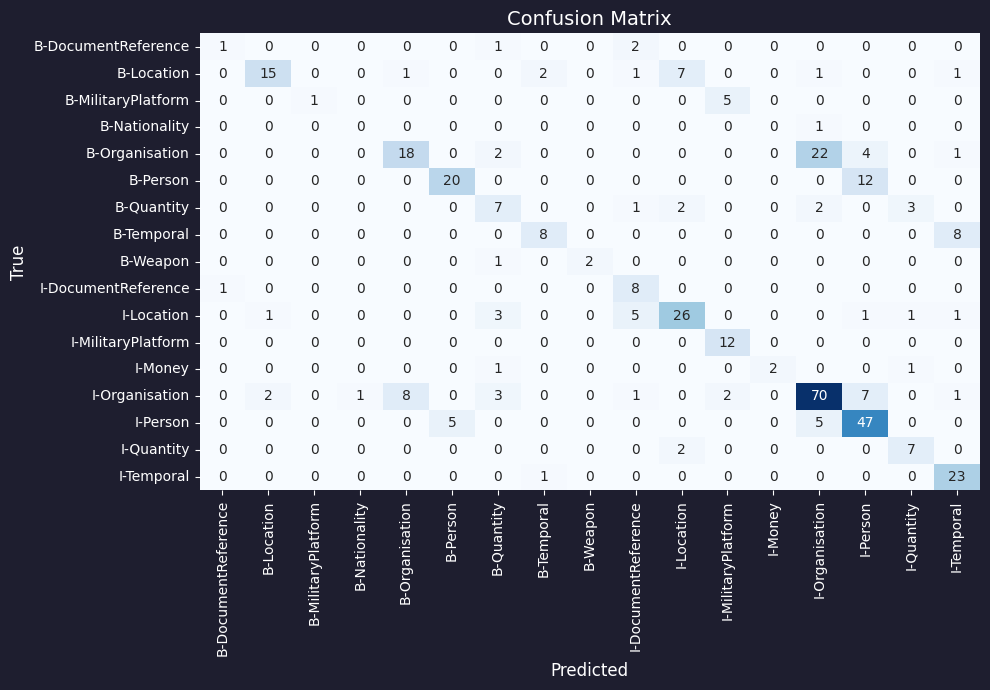

Grafico salvato in: /content/drive/MyDrive/Colab Notebooks/BERT TRIAL 2/plots/confusion_matrix2_lstm.png


In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import os

def plot_custom_confusion_matrix(cm, labels, save_dir):

    plt.figure(figsize=(10, 7), facecolor='#1E1E2F')


    ax = sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels, cbar=False)


    ax.set_xlabel('Predicted', fontsize=12, color='white')
    ax.set_ylabel('True', fontsize=12, color='white')
    ax.set_title('Confusion Matrix', fontsize=14, color='white')


    ax.tick_params(axis='x', colors='white')
    ax.tick_params(axis='y', colors='white')


    ax.set_facecolor('#1E1E2F')
    plt.tight_layout()


    confusion_matrix_plot_path = os.path.join(save_dir, 'confusion_matrix2_lstm.png')
    plt.savefig(confusion_matrix_plot_path, facecolor='#1E1E2F')
    plt.show()

    print(f"Grafico salvato in: {confusion_matrix_plot_path}")

def compute_and_plot_custom_confusion_matrix(y_pred_flat, y_true_flat, int_to_tag, save_dir):

    all_true_labels = []
    all_predictions = []


    for pred, true in zip(y_pred_flat, y_true_flat):
        if true != 20 and pred != 20:
            all_true_labels.append(true)
            all_predictions.append(pred)


    unique_labels = list(set(all_true_labels) & set(all_predictions))


    display_labels = [int_to_tag[label] for label in unique_labels]


    cm = confusion_matrix(all_true_labels, all_predictions, labels=unique_labels)


    plot_custom_confusion_matrix(cm, display_labels, save_dir)

save_dir = '/content/drive/MyDrive/Colab Notebooks/BERT TRIAL 2/plots'
os.makedirs(save_dir, exist_ok=True)


compute_and_plot_custom_confusion_matrix(y_pred_flat, y_true_flat, int_to_tag, save_dir)


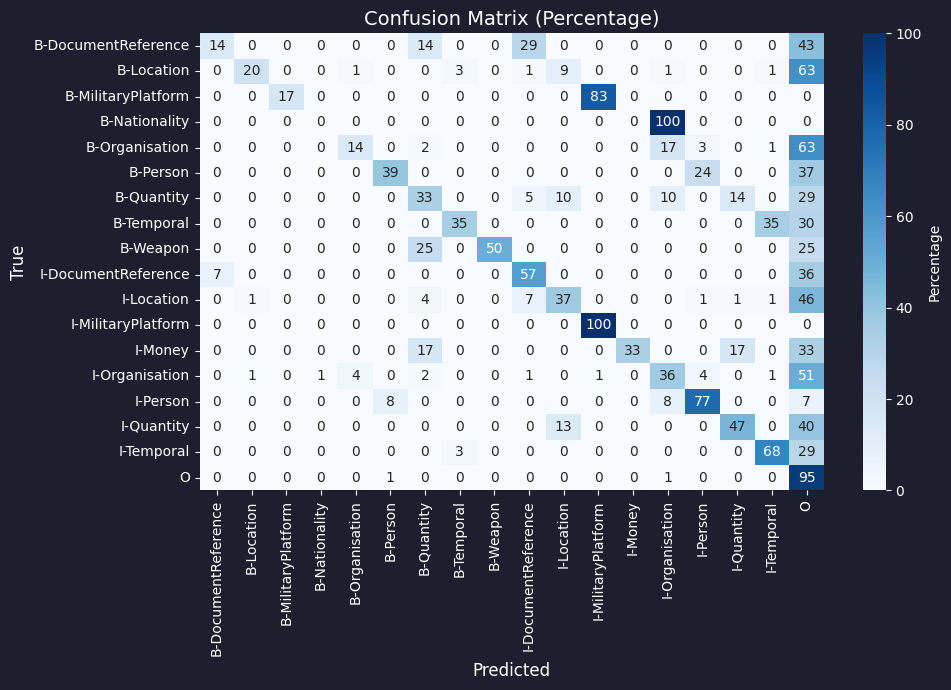

Grafico salvato in: /content/drive/MyDrive/Colab Notebooks/BERT TRIAL 2/plots/confusion_matrix_percentage_lstm.png


In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import os

def plot_custom_confusion_matrix(cm, labels, save_dir):

    cm_percentage = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100


    plt.figure(figsize=(10, 7), facecolor='#1E1E2F')


    ax = sns.heatmap(cm_percentage, annot=True, fmt='.0f', cmap='Blues', xticklabels=labels, yticklabels=labels, cbar_kws={'label': 'Percentage'})


    for text in ax.texts:
        text.set_fontsize(10)


    ax.set_xlabel('Predicted', fontsize=12, color='white')
    ax.set_ylabel('True', fontsize=12, color='white')
    ax.set_title('Confusion Matrix (Percentage)', fontsize=14, color='white')


    ax.tick_params(axis='x', colors='white')
    ax.tick_params(axis='y', colors='white')


    ax.set_facecolor('#1E1E2F')
    ax.collections[0].colorbar.ax.yaxis.set_tick_params(color='white')
    plt.setp(ax.collections[0].colorbar.ax.get_yticklabels(), color='white')


    plt.tight_layout()
    confusion_matrix_plot_path = os.path.join(save_dir, 'confusion_matrix_percentage_lstm.png')
    plt.savefig(confusion_matrix_plot_path, facecolor='#1E1E2F')
    plt.show()

    print(f"Grafico salvato in: {confusion_matrix_plot_path}")

def compute_and_plot_custom_confusion_matrix(y_pred_flat, y_true_flat, int_to_tag, save_dir):

    all_true_labels = []
    all_predictions = []


    for pred, true in zip(y_pred_flat, y_true_flat):
        if true != -200 and pred != -200:
            all_true_labels.append(true)
            all_predictions.append(pred)


    unique_labels = list(set(all_true_labels) & set(all_predictions))


    display_labels = [int_to_tag[label] for label in unique_labels]


    cm = confusion_matrix(all_true_labels, all_predictions, labels=unique_labels)


    plot_custom_confusion_matrix(cm, display_labels, save_dir)


save_dir = '/content/drive/MyDrive/Colab Notebooks/BERT TRIAL 2/plots'
os.makedirs(save_dir, exist_ok=True)


compute_and_plot_custom_confusion_matrix(y_pred_flat, y_true_flat, int_to_tag, save_dir)


NER is performed on an input sentence using the trained model. The input sentence is tokenized and converted into a sequence of numerical tokens. To ensure compatibility with the model, the tokenized sentence is padded to the fixed maximum sequence length. The model then predicts the IOB tags for each token in the sentence.

To handle padding effectively, the code dynamically determines the actual length of the input sentence and excludes any predictions related to padding tokens. The predicted labels are mapped back to their corresponding tag names using the `int_to_tag` dictionary.

Finally, the original tokens and their predicted labels are organized into a structured format using a pandas DataFrame, for a clear and concise output.

In [ ]:
# PREDICT A NEW SENTENCE
import pandas as pd
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Sample sentence for prediction
sentence_prediction = 'President Carter is an american president'
# Tokenization and padding
tokenized_sentence = tokenizer.texts_to_sequences([sentence_prediction])[0]
sentence_length = len(tokenized_sentence)  # Get the actual sentence length

padded_sentence = pad_sequences([tokenized_sentence], maxlen=max_sequence_len, padding='post')

int_to_tag = {idx: tag for tag, idx in tag_to_int.items()}

# Model prediction
IOB_prediction = model.predict(padded_sentence, batch_size=1, verbose=2)[0]
predicted_values = np.argmax(IOB_prediction, axis=-1)

predicted_tags = [int_to_tag[idx] for idx in predicted_values[:sentence_length]]
original_tokens = tokenizer.sequences_to_texts([tokenized_sentence])[0].split()

output_df = pd.DataFrame({
    'Token': original_tokens,
    'Predicted_Label': predicted_tags})

print(output_df)

1/1 - 0s - 170ms/step
       Token Predicted_Label
0  president        B-Person
1     carter        B-Person
2         is               O
3         an               O
4   american               O
5  president        I-Person


# 3) BERT MODEL

In [ ]:
%reset -f

DATA LOADING, CLEANING, DATAFRAMES AND IMPORTING SPACY

In [ ]:
import pandas as pd
import spacy
nlp = spacy.load('en_core_web_sm')
from spacy.tokens import Doc, Span
import numpy as np
import os

from google.colab import drive
drive.mount('/content/drive')

drive_path = '/content/drive/MyDrive/Colab Notebooks/BERT TRIAL 2'
file_path = os.path.join(drive_path, 'file1.ann')
file_path2 = os.path.join(drive_path, 'file2.ann')

def create_dataframe(content):
    with open(content, 'r', encoding='utf-8') as file:
        lines = file.readlines()
    data = [line.split() for line in lines]
    df = pd.DataFrame(data, columns=['token', 'tag'])
    df = df.drop(index=df.index[0])
    return df

df_file1 = create_dataframe(file_path)
df_file2 = create_dataframe(file_path2)

df_file1 = pd.concat([df_file1, df_file2], ignore_index=True)

def pulisci_df(df):
    def is_arabic(word):
        if word is None or pd.isnull(word):
            return True
        word = str(word)
        return any('\u0600' <= char <= '\u06FF' for char in word)

    mask = df['token'].apply(is_arabic)
    return df[~mask]

df_file1 = pulisci_df(df_file1)
df_file1 = df_file1.reset_index(drop=True)

print(df_file1.head())

def pulisci_file(df, column_name):
    result = df[column_name].str.cat(sep=' ')
    return result

file1_text = pulisci_file(df_file1, 'token')

doc1 = nlp(file1_text)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
       token tag
0  Operation   O
1      Steel   O
2    Curtain   O
3          (   O
4     Arabic   O



The code loads text data from two annotation files stored in Google Drive. It reads the files, splits each line into tokens and tags, and stores them in a DataFrame. It then merges the two datasets into one. A cleaning function removes any words containing Arabic characters. After resetting the index, the cleaned text is concatenated into a single string. Finally, the text is processed using the spaCy language model for further natural language processing tasks.

CHANGE SPACY'S TAGGING SYSTEM TO IOB2 (ORIGINAL FORMAT OF THE DATASET)

In [ ]:
from spacy.training import align

original_tokens = df_file1["token"].tolist()
spacy_tokens = [token.text for token in doc1]

alignments = align.get_alignments(original_tokens, spacy_tokens)

aligned_iob2 = ["O"] * len(spacy_tokens)

for original_idx, spacy_indices in enumerate(alignments[0]):
    tag = df_file1["tag"][original_idx]
    if len(spacy_indices) == 1:
        aligned_iob2[spacy_indices[0]] = tag
    else:
        for idx in spacy_indices:
            aligned_iob2[idx] = tag

df_test = pd.DataFrame({'tokens': spacy_tokens, 'tag': aligned_iob2})

The code aligns tokens from the original dataset with tokens processed by spaCy. It first extracts tokens from the DataFrame and the spaCy-processed document. The align.get_alignments() function maps original tokens to their corresponding spaCy tokens. A new list is initialized with "O" tags, meaning no entity. Then, for each original token, the corresponding tag is assigned to the aligned spaCy tokens. If a token splits into multiple spaCy tokens, all are assigned the same tag. Finally, a new DataFrame is created containing the spaCy tokens and their aligned tags.

REPLACE DOC1 TAGS WITH THE ORIGINAL IOB2 TAGS

In [ ]:
def extract_entities(df, tag_column="tag"):
    entities = []
    current_entity = None

    for index, row in df.iterrows():
        tag = row[tag_column]

        if tag.startswith("B-"):  # Begin a new entity
            if current_entity:  # Save the previous entity
                entities.append(current_entity)
            entity_type = tag[2:]  # Extract the entity type
            current_entity = {"type": entity_type, "start": index, "end": index + 1}

        elif tag.startswith("I-") and current_entity:  # Inside an entity
            entity_type = tag[2:]
            if current_entity["type"] == entity_type:  # Ensure it's the same entity type
                current_entity["end"] = index + 1  # Extend the current entity

        else:  # Outside any entity
            if current_entity:  # Save the current entity
                entities.append(current_entity)
                current_entity = None

    # Add the last entity if it exists
    if current_entity:
        entities.append(current_entity)

    return entities


This function extracts named entities from a DataFrame containing tokenized text and their corresponding tags. It iterates through the DataFrame row by row, checking the tag of each token. If a tag starts with "B-", a new entity begins, and the previous entity (if any) is saved. If a tag starts with "I-", the function extends the current entity, provided it matches the same type. If a token has no entity tag, the function saves the current entity and resets. Finally, it returns a list of all extracted entities, each represented as a dictionary containing the entity type, start index, and end index.

EXTRACTING ENTITIES

In [ ]:

custom_entities = extract_entities(df_test)

doc1.ents = [Span(doc1, entity["start"], entity["end"], label=entity["type"]) for entity in custom_entities]
doc1.set_ents(doc1.ents, default="outside")


The code extracts named entities from the df_test DataFrame using the extract_entities function. It then creates spaCy Span objects for each entity, which represent the start and end positions of the entity in the doc1 spaCy document. These spans are labeled with the entity type and assigned to the doc1 document. Any tokens not part of an entity are labeled as "outside." This process prepares the document for further entity analysis or visualization.

CREATE A DF WITH GRAMMATICAL INFO AND TAG

In [ ]:
data = []
for token in doc1:
    data.append([
        getattr(token, "text"),      # Token text
        getattr(token, "lemma_", None),   # Lemma
        getattr(token, "pos_", None),     # Part-of-speech tag
        getattr(token, "dep_", None),     # Dependency label
        getattr(token.head, "text", None),# Head text
        f"{token.ent_iob_}-{token.ent_type_}" if token.ent_type_ else "O"
    ])


The code processes each token in a spaCy document, extracting key information like the token's text, lemma, part of speech, dependency label, head token, and entity information (if applicable). It stores this data in a list, with each element representing a token's features. If a token is part of an entity, it includes the IOB tag and entity type; otherwise, it assigns the label "O".

In [ ]:
def join_and_clear(df, col_name, row1, row2):
    df.at[row1, col_name] = f"{df.at[row1, col_name]} {df.at[row2, col_name]}"
    df.loc[row2] = [None] * len(df.columns)

The function join_and_clear performs two tasks. It concatenates the values from two rows of a specified column into a single value. Specifically, it combines the value of col_name from row1 and row2, and stores this combined value in row1. After that, it clears all the data in row2, essentially setting all the values in that row to None. This function is useful for merging adjacent rows while cleaning up the second one.

In [ ]:
df = pd.DataFrame(data, columns=["token", "Lemma", "POS", "DEP", "Head", "tag"])

CREATE A DF WITH THE SENTENCES


In [ ]:
data = []

for sent in doc1.sents:
    sentence_text = sent.text
    iob_tags = []
    for token in sent:
        if token.ent_iob_ == "O":
            iob_tags.append(token.ent_iob_)
        else:
            iob_tags.append(token.ent_iob_ + "-" + token.ent_type_)
    iob_tags_str = ' '.join(iob_tags)
    data.append({"sentence": sentence_text, "IOB_tag": iob_tags_str})

df1 = pd.DataFrame(data)


def build_tag2unique(df, tag_column="IOB_tag"):
    all_tags = df[tag_column].str.split().sum()
    unique_tags = set(all_tags)
    tag2unique = {tag: idx for idx, tag in enumerate(sorted(unique_tags))}

    return tag2unique

tag2unique = build_tag2unique(df1, tag_column="IOB_tag")
print("tag2unique:", tag2unique)


tag2unique: {'B-DocumentReference': 0, 'B-Location': 1, 'B-MilitaryPlatform': 2, 'B-Money': 3, 'B-Nationality': 4, 'B-Organisation': 5, 'B-Person': 6, 'B-Quantity': 7, 'B-Temporal': 8, 'B-Weapon': 9, 'I-DocumentReference': 10, 'I-Location': 11, 'I-MilitaryPlatform': 12, 'I-Money': 13, 'I-Nationality': 14, 'I-Organisation': 15, 'I-Person': 16, 'I-Quantity': 17, 'I-Temporal': 18, 'I-Weapon': 19, 'O': 20}


The code processes sentences from a spaCy document (doc1), extracting the sentence text and IOB tags for each token. It generates a dataframe where each row contains a sentence and its corresponding IOB tags, marking tokens outside entities as "O" and tagging tokens within entities with the appropriate IOB type. The resulting dataframe contains sentences along with their entity annotations.

1.1) TRAINING AND VALIDATION DIVISION

In [ ]:
from sklearn.model_selection import train_test_split
np.random.seed(42)

train_sentences, temp_sentences, train_tags, temp_tags = train_test_split(
    df1["sentence"], df1["IOB_tag"], test_size=0.3, random_state=42
)

val_sentences, test_sentences, val_tags, test_tags = train_test_split(
    temp_sentences, temp_tags, test_size=0.3333, random_state=42
)

#TOKENIZATION AND TAG ADJUSTMENT
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

def tokenize_and_align_labels(sentences, tags, tokenizer, tag2unique):
    input_ids_list = []
    attention_mask_list = []
    aligned_labels_list = []

    for sentence, tag_seq in zip(sentences, tags):
        sentence_tokens = sentence.split()
        tokenized_sentence = tokenizer(
            sentence_tokens,
            is_split_into_words=True,
            truncation=True,
            padding="max_length",
            max_length=128,
            return_tensors="pt"
        )

        word_ids = tokenized_sentence.word_ids()
        aligned_tags = []
        attention_mask = tokenized_sentence["attention_mask"].squeeze().tolist()
        tag_list = tag_seq.split()


        for word_idx in word_ids:
            if word_idx is None:
                aligned_tags.append(-100)
            else:

                tag = tag_list[word_idx]
                if tag == 'O':
                    aligned_tags.append(tag2unique[tag])
                else:
                    aligned_tags.append(tag2unique[tag])



        for idx, label in enumerate(aligned_tags):
            if label == -100:
                attention_mask[idx] = 0


        input_ids_list.append(tokenized_sentence["input_ids"].squeeze().tolist())
        attention_mask_list.append(attention_mask)
        aligned_labels_list.append(aligned_tags)

    return input_ids_list, attention_mask_list, aligned_labels_list



train_input_ids, train_attention_mask, train_labels = tokenize_and_align_labels(train_sentences, train_tags, tokenizer, tag2unique)
val_input_ids, val_attention_mask, val_labels = tokenize_and_align_labels(val_sentences, val_tags, tokenizer, tag2unique)
test_input_ids, test_attention_mask, test_labels = tokenize_and_align_labels(test_sentences, test_tags, tokenizer, tag2unique)



/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

The code starts by importing the necessary libraries, specifically train_test_split from sklearn.model_selection for splitting data and setting a random seed for reproducibility. It then splits the dataset (df1["sentence"] and df1["IOB_tag"]) into training, validation, and test sets, with 70% for training, 20% for validation, and 10% for testing. Next, it imports AutoTokenizer from the transformers library to handle tokenization using the distilbert-base-uncased pre-trained model. A function tokenize_and_align_labels is defined to tokenize sentences and align the tags with the tokens. For each sentence in the dataset, the sentence is split into tokens, and the tokenizer is applied to convert the sentence into token IDs while applying padding and truncation. The word IDs from the tokenized sentence are used to align the original labels (tags) to the tokenized tokens. If a token is not associated with a word, the label is set to -100, indicating it should be ignored during loss calculation. The attention mask is adjusted accordingly, where tokens that do not correspond to words (i.e., padding tokens) have an attention mask of 0. After processing all sentences, the function returns lists of token IDs, attention masks, and aligned labels. The function is then called for the training, validation, and test sets, producing the respective tokenized inputs, attention masks, and labels for each set.

1.2) PROPER DATASET FOR TRAINING

In [ ]:
!pip install datasets


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 485.4/485.4 kB 10.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 14.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 18.6 MB/s eta 0:00:00


In [ ]:
from datasets import Dataset

train_dataset = Dataset.from_dict({
    "input_ids": train_input_ids,
    "attention_mask": train_attention_mask,
    "labels": train_labels
})

val_dataset = Dataset.from_dict({
    "input_ids": val_input_ids,
    "attention_mask": val_attention_mask,
    "labels": val_labels
})

test_dataset = Dataset.from_dict({
    "input_ids": test_input_ids,
    "attention_mask": test_attention_mask,
    "labels": test_labels
})


1.3) TENSORS FOR INPUTS

In [ ]:
train_input_ids = [item["input_ids"] for item in train_dataset]
train_attention_mask = [item["attention_mask"] for item in train_dataset]

val_input_ids = [item["input_ids"] for item in val_dataset]
val_attention_mask = [item["attention_mask"] for item in val_dataset]

test_input_ids = [item["input_ids"] for item in test_dataset]
test_attention_mask = [item["attention_mask"] for item in test_dataset]


The code processes tokenized sentences to create the input_ids and attention_mask needed for a model like BERT. The input_ids represent the tokens from the sentence converted into their corresponding integer IDs using a tokenizer. The attention_mask is a binary mask where 1 indicates that the token should be attended to and 0 means it is a padding token and should be ignored. The code extracts both input_ids and attention_mask for the training, validation, and test datasets, ensuring that padding tokens do not affect the model's attention mechanism. These components are essential for training and testing a machine learning model like BERT

2) TRAINING

In [ ]:
import os
os.environ["WANDB_DISABLED"] = "true"

In [ ]:
from collections import Counter
import torch
def compute_class_weights(labels, num_classes):
    flat_labels = [label for sublist in labels for label in sublist]
    class_counts = Counter(flat_labels)
    total_tokens = sum(class_counts.values())
    class_weights = [
        total_tokens / (num_classes * class_counts.get(cls, 1))
        for cls in range(num_classes)
    ]
    return torch.tensor(class_weights).float().to(device)


The code defines a function compute_class_weights that calculates the class weights for a token classification task based on the frequency of labels. It flattens the label list, counts the occurrences of each label, and computes the weight for each class using the total number of tokens and the number of classes. The weights are returned as a tensor to be used during model training, addressing potential class imbalances.

In [ ]:
import torch
from collections import Counter

label_set = set(label for seq in train_labels for label in seq if label != -100)
label_to_id = {label: idx for idx, label in enumerate(sorted(label_set))}
id_to_label = {idx: label for label, idx in label_to_id.items()}

train_labels_ids = [[label_to_id[label] for label in seq if label != -100] for seq in train_labels]

all_labels_ids = [label for seq in train_labels_ids for label in seq]

def compute_class_weights(labels, num_classes):

    class_counts = Counter(labels)
    total_tokens = sum(class_counts.values())


    class_weights = torch.tensor([total_tokens / class_counts.get(i, 1) for i in range(num_classes)])

    return class_weights

class_weights = compute_class_weights(all_labels_ids, num_classes=len(label_to_id))

print(f"Class weights: {class_weights}")


Class weights: tensor([5.4689e+02, 2.6511e+01, 3.0383e+02, 1.2761e+03, 4.5574e+02, 1.6263e+01,
        4.1976e+01, 1.4392e+02, 1.1963e+02, 2.4858e+02, 1.7090e+02, 2.2283e+01,
        2.2519e+02, 5.6297e+02, 3.8282e+03, 1.2168e+01, 2.6659e+01, 2.3631e+02,
        1.0634e+02, 2.8569e+02, 1.5255e+00])


In [ ]:
class_weights = compute_class_weights(all_labels_ids, num_classes=len(label_to_id))

min_weight = 1.0
max_weight = 4.0

class_weights_min = class_weights.min()
class_weights_max = class_weights.max()
scaled_class_weights = (class_weights - class_weights_min) / (class_weights_max - class_weights_min)
scaled_class_weights = scaled_class_weights * (max_weight - min_weight) + min_weight

print(f"Scaled weights (1-4): {scaled_class_weights}")


Scaled weights (1-4): tensor([1.4275, 1.0196, 1.2370, 1.9992, 1.3561, 1.0116, 1.0317, 1.1116, 1.0926,
        1.1937, 1.1328, 1.0163, 1.1753, 1.4402, 4.0000, 1.0083, 1.0197, 1.1841,
        1.0822, 1.2228, 1.0000])


In [ ]:
import torch
import torch.nn.functional as F

class FocalLoss(torch.nn.Module):
    def __init__(self, alpha=None, gamma=2.0, reduction="mean"):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, logits, labels):
        # Mascherare i valori di padding (-100)
        mask = (labels != -100)


        logits = logits[mask]
        labels = labels[mask]


        if len(labels) == 0:
            return torch.tensor(0.0, device=logits.device)

        probs = F.softmax(logits, dim=-1)
        log_probs = F.log_softmax(logits, dim=-1)

        labels_one_hot = F.one_hot(labels, num_classes=logits.size(-1)).float()
        probs = (probs * labels_one_hot).sum(dim=-1)
        log_probs = (log_probs * labels_one_hot).sum(dim=-1)

        focal_term = (1 - probs) ** self.gamma

        loss = -focal_term * log_probs


        if self.alpha is not None:
            alpha_t = self.alpha[labels.to(self.alpha.device)]
            loss = alpha_t * loss

        if self.reduction == "mean":
            return loss.mean()
        elif self.reduction == "sum":
            return loss.sum()
        else:
            return loss


focal_loss = FocalLoss(alpha=scaled_class_weights.to(device), gamma=2.0)

def custom_forward(inputs, labels):

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    inputs = {key: value.to(device) for key, value in inputs.items()}
    labels = labels.to(device)

    logits = model(**inputs).logits
    loss = focal_loss(logits.view(-1, logits.size(-1)), labels.view(-1))
    return loss, logits



The code defines a custom FocalLoss class designed to improve performance in scenarios where the dataset has class imbalance. This loss function modifies the standard cross-entropy loss by focusing more on difficult examples, which are typically underrepresented in imbalanced datasets.

The FocalLoss class contains an initialization method where parameters such as alpha, gamma, and reduction are defined. Alpha helps balance the importance of different classes, especially when there is class imbalance. Gamma controls the focus on harder examples by reducing the loss for well-classified examples. The reduction parameter defines how to aggregate the loss, either by averaging or summing it.

The forward method calculates the loss. It first applies softmax to the logits to convert them into probabilities and uses one-hot encoding to match the true labels with the predicted probabilities. A focal term is computed to emphasize harder examples. The loss is then calculated by combining the focal term and the log-probabilities. If alpha is specified, it is applied to weight the loss for each class. The loss is returned, reduced according to the specified method.

Finally, a custom forward function (custom_forward) is provided. This function calculates the model's logits and computes the focal loss by comparing these logits with the true labels. The result is the loss and the logits, which can be used for further training steps.

In [ ]:
from transformers import Trainer

class WeightedTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False, num_items_in_batch=None):
        labels = inputs.pop("labels")
        outputs = model(**inputs)
        logits = outputs.logits

        loss = focal_loss(logits.view(-1, model.config.num_labels), labels.view(-1))
        return (loss, outputs) if return_outputs else loss



In [ ]:
def save_metrics_to_csv(metrics_dict, file_path):
    file_exists = os.path.isfile(file_path)
    with open(file_path, mode='a', newline='') as file:
        writer = csv.DictWriter(file, fieldnames=metrics_dict.keys())

        if not file_exists:
            writer.writeheader()


        print(f"Saving to CSV: {metrics_dict}")
        writer.writerow(metrics_dict)


In [ ]:
import numpy as np
import os
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

import random
import torch

np.random.seed(12345)

random.seed(12345)

torch.manual_seed(12345)
torch.cuda.manual_seed_all(12345)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

from transformers import AutoModelForTokenClassification, Trainer, TrainingArguments, DataCollatorForTokenClassification
from sklearn.metrics import accuracy_score, f1_score
from transformers import AutoTokenizer
import torch
from datasets import Dataset
import csv
import os
import numpy as np
from tqdm.auto import tqdm
from google.colab import drive

drive.mount('/content/drive')

drive_path = '/content/drive/My Drive/Colab Notebooks/BERT TRIAL 2'
train_metrics_file = os.path.join(drive_path, 'train_metrics.csv')
val_metrics_file = os.path.join(drive_path, 'val_metrics.csv')
model_save_path = os.path.join(drive_path, 'final_model')

model_ckpt = "distilbert-base-uncased"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)
model = AutoModelForTokenClassification.from_pretrained(model_ckpt, num_labels=21).to(device)

data_collator = DataCollatorForTokenClassification(tokenizer)

def compute_metrics(p):
    predictions, labels = p
    predictions = predictions.argmax(axis=-1).flatten()
    labels = labels.flatten()

    mask = (labels != 20) & (labels != -100)
    filtered_labels = labels[mask]
    filtered_predictions = predictions[mask]

    accuracy = accuracy_score(filtered_labels, filtered_predictions)
    f1_macro = f1_score(filtered_labels, filtered_predictions, average='macro')
    f1_weighted = f1_score(filtered_labels, filtered_predictions, average='weighted')

    return {
    'accuracy': accuracy,
    'f1_macro': f1_macro,
    'f1_weighted': f1_weighted
    }

def save_metrics_to_csv(metrics_dict, file_path):
    file_exists = os.path.isfile(file_path)
    with open(file_path, mode='a', newline='') as file:
        writer = csv.DictWriter(file, fieldnames=metrics_dict.keys())

        if not file_exists:
            writer.writeheader()

        print(f"Saving to CSV: {metrics_dict}")
        writer.writerow(metrics_dict)

training_args = TrainingArguments(
    output_dir=os.path.join(drive_path, 'results'),
    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    warmup_steps=170,
    weight_decay=0.005,
    logging_dir=os.path.join(drive_path, 'logs'),
    logging_steps=50,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    save_total_limit=2,
    fp16=True,
    report_to=None
)

trainer = WeightedTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
    data_collator=data_collator
)

print("Starting training...")
previous_val_loss = float('inf')

for epoch in range(training_args.num_train_epochs):
    print(f"Epoch {epoch + 1}/{training_args.num_train_epochs}")
    trainer.train()

    val_results = trainer.evaluate()
    val_loss = val_results['eval_loss']
    val_metrics = {
    "epoch": epoch + 1,
    "eval_loss": val_loss,
    "eval_accuracy": val_results.get('eval_accuracy', 'N/A'),
    "eval_f1_macro": val_results.get('eval_f1_macro', 'N/A'),
    "eval_f1_weighted": val_results.get('eval_f1_weighted', 'N/A')
    }

    save_metrics_to_csv(val_metrics, val_metrics_file)

    # Log training loss
    if trainer.state.log_history and 'train_loss' in trainer.state.log_history[-1]:
        train_loss = trainer.state.log_history[-1]['train_loss']
    else:
        train_loss = 'N/A'


    train_accuracy = 'N/A'
    if trainer.state.log_history:
        for log in trainer.state.log_history:
            if 'eval_accuracy' in log:
                train_accuracy = log['eval_accuracy']
                break

    train_metrics = {
        "epoch": epoch + 1,
        "train_loss": train_loss,
        "train_accuracy": train_accuracy
    }
    save_metrics_to_csv(train_metrics, train_metrics_file)


    if val_loss > previous_val_loss:
        print(f"Early stopping: validation loss increased from {previous_val_loss:.4f} to {val_loss:.4f} at epoch {epoch + 1}.")
        break

    previous_val_loss = val_loss

print("Saving final model...")
model.save_pretrained(model_save_path)
tokenizer.save_pretrained(model_save_path)
print(f"Model saved in: {model_save_path}")

# Report finale
print("Completed training. Final metrics saved.")


Some weights of DistilBertForTokenClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Starting training...
Epoch 1/3


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro,F1 Weighted
1,No log,1.149198,0.000000,0.000000,0.000000
2,1.874000,0.640605,0.413091,0.135310,0.412580
3,0.789300,0.387124,0.614411,0.326367,0.642531


Saving to CSV: {'epoch': 1, 'eval_loss': 0.3871240019798279, 'eval_accuracy': 0.6144114411441144, 'eval_f1_macro': 0.3263671797273557, 'eval_f1_weighted': 0.6425313863796798}
Saving to CSV: {'epoch': 1, 'train_loss': 'N/A', 'train_accuracy': 0.0}
Epoch 2/3


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro,F1 Weighted
1,No log,0.353338,0.627063,0.363284,0.674900
2,0.275300,0.308889,0.682618,0.450059,0.729794
3,0.210000,0.299650,0.687569,0.465831,0.743921


Saving to CSV: {'epoch': 2, 'eval_loss': 0.29964974522590637, 'eval_accuracy': 0.6875687568756875, 'eval_f1_macro': 0.4658309106422398, 'eval_f1_weighted': 0.7439207087852705}
Saving to CSV: {'epoch': 2, 'train_loss': 'N/A', 'train_accuracy': 0.6270627062706271}
Epoch 3/3


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro,F1 Weighted
1,No log,0.289759,0.727173,0.534321,0.779894
2,0.118300,0.297952,0.705721,0.552008,0.764197
3,0.087600,0.292868,0.765127,0.566795,0.800870


Saving to CSV: {'epoch': 3, 'eval_loss': 0.2928677797317505, 'eval_accuracy': 0.7651265126512651, 'eval_f1_macro': 0.5667947038352826, 'eval_f1_weighted': 0.800869919577061}
Saving to CSV: {'epoch': 3, 'train_loss': 'N/A', 'train_accuracy': 0.7271727172717272}
Saving final model...
Model saved in: /content/drive/My Drive/Colab Notebooks/BERT TRIAL 2/final_model
Completed training. Final metrics saved.


The provided code outlines the process of training a token classification model using the Hugging Face Transformers library with a custom setup. Here’s what happens step by step:

The code sets the seed for reproducibility using numpy, random, and torch. This ensures that the results will be consistent across different runs of the script. The model and data are loaded from Google Drive, and the model checkpoint (distilbert-base-uncased) is set for the fine-tuning task. The device is set to use CUDA if available.

The model, tokenizer, and data collator are initialized. The model is loaded as a token classification model with 21 labels, and the tokenizer is loaded to handle tokenization during training. The data collator helps manage how data is batched during training.

The compute_metrics function computes accuracy and F1 scores (both macro and weighted) after each evaluation phase. This is used to assess model performance.

Metrics are saved to CSV files after every epoch of evaluation using the save_metrics_to_csv function. This helps track training and validation metrics throughout the training process.

Training parameters are defined using TrainingArguments. This includes settings like batch size, number of epochs, evaluation strategy, and logging frequency. Additionally, mixed-precision training is enabled to speed up training and reduce memory usage (fp16=True).

The WeightedTrainer is created to handle training and evaluation with the model, datasets, and compute metrics function. The training loop begins, and for each epoch, the model is trained, evaluated on the validation set, and the metrics are saved.

If the validation loss increases compared to the previous epoch, early stopping is triggered, and training is stopped to prevent overfitting. The final model is saved to the specified directory after training finishes.

This script is designed to save model checkpoints, track metrics, and implement early stopping to optimize model training for token classification tasks.

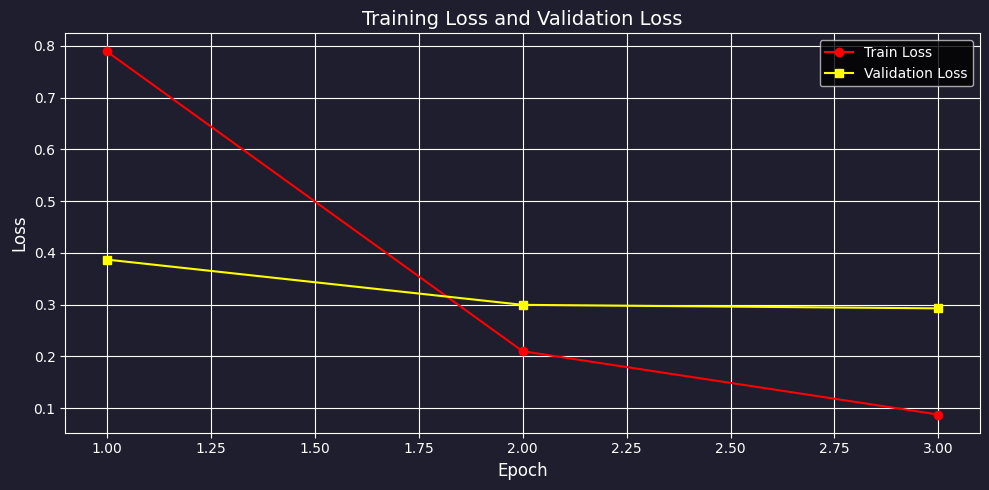

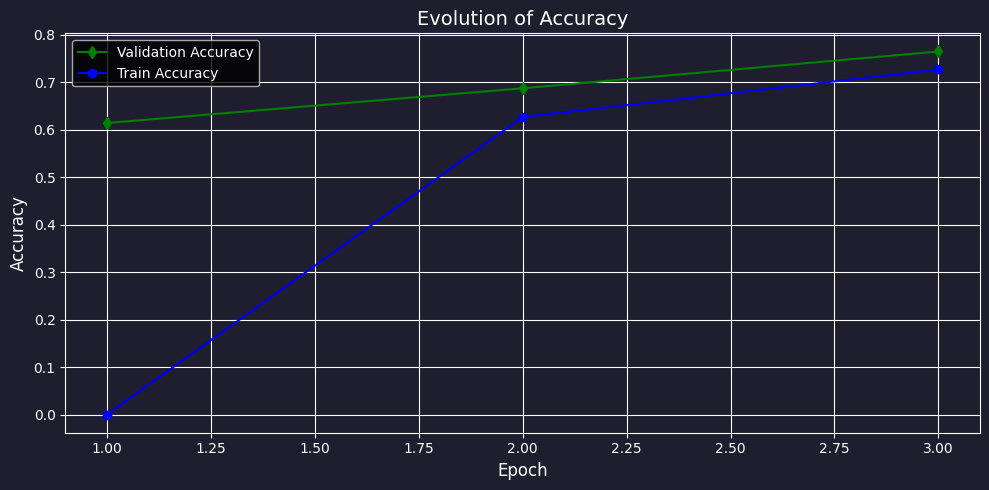

Grafici salvati in: /content/drive/MyDrive/Colab Notebooks/BERT TRIAL 2/plots


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import os

drive_path = "/content/drive/My Drive/Colab Notebooks/BERT TRIAL 2"
train_metrics_file = os.path.join(drive_path, "train_metrics.csv")
val_metrics_file = os.path.join(drive_path, "val_metrics.csv")

train_metrics = pd.read_csv(train_metrics_file)
val_metrics = pd.read_csv(val_metrics_file)

train_loss_values = [0.789300, 0.210000, 0.087600]
train_metrics["train_loss"] = train_loss_values

train_metrics["train_loss"] = pd.to_numeric(train_metrics["train_loss"], errors="coerce")
val_metrics["eval_loss"] = pd.to_numeric(val_metrics["eval_loss"], errors="coerce")
val_metrics["eval_accuracy"] = pd.to_numeric(val_metrics["eval_accuracy"], errors="coerce")
train_metrics["train_accuracy"] = pd.to_numeric(train_metrics["train_accuracy"], errors="coerce")

save_dir = '/content/drive/MyDrive/Colab Notebooks/BERT TRIAL 2/plots'
os.makedirs(save_dir, exist_ok=True)

fig, ax = plt.subplots(figsize=(10, 5), facecolor='#1E1E2F')
ax.plot(train_metrics["epoch"], train_metrics["train_loss"], label="Train Loss", marker="o", color="red")
ax.plot(val_metrics["epoch"], val_metrics["eval_loss"], label="Validation Loss", marker="s", color="yellow")

ax.set_xlabel("Epoch", fontsize=12, color='white')
ax.set_ylabel("Loss", fontsize=12, color='white')
ax.set_title("Training Loss and Validation Loss", fontsize=14, color='white')
ax.legend()
ax.grid(True, color='white')

ax.set_facecolor('#1E1E2F')
fig.patch.set_facecolor('#1E1E2F')

ax.tick_params(axis='x', colors='white')
ax.tick_params(axis='y', colors='white')

plt.tight_layout()
train_loss_plot_path = os.path.join(save_dir, 'train_validation_loss_bert.png')
plt.savefig(train_loss_plot_path, facecolor=fig.get_facecolor())
plt.show()

fig, ax = plt.subplots(figsize=(10, 5), facecolor='#1E1E2F')
ax.plot(val_metrics["epoch"], val_metrics["eval_accuracy"], label="Validation Accuracy", marker="d", color="green")
ax.plot(train_metrics["epoch"], train_metrics["train_accuracy"], label="Train Accuracy", marker="o", color="blue")

ax.set_xlabel("Epoch", fontsize=12, color='white')
ax.set_ylabel("Accuracy", fontsize=12, color='white')
ax.set_title("Evolution of Accuracy", fontsize=14, color='white')
ax.legend()
ax.grid(True, color='white')


ax.set_facecolor('#1E1E2F')
fig.patch.set_facecolor('#1E1E2F')


ax.tick_params(axis='x', colors='white')
ax.tick_params(axis='y', colors='white')


plt.tight_layout()
accuracy_plot_path = os.path.join(save_dir, 'train_and_validation_accuracy_bert.png')
plt.savefig(accuracy_plot_path, facecolor=fig.get_facecolor())
plt.show()

print(f"Grafici salvati in: {save_dir}")


3) BERT TEST

In [ ]:
%reset -f

Loading the model

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
from transformers import AutoModelForTokenClassification, AutoTokenizer
import torch

model_path = "/content/drive/My Drive/Colab Notebooks/BERT TRIAL 2/final_model"

tokenizer = AutoTokenizer.from_pretrained(model_path)
model = AutoModelForTokenClassification.from_pretrained(model_path).to("cuda" if torch.cuda.is_available() else "cpu")
model.to("cuda")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


DistilBertForTokenClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): DistilBertSdpaAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
   

Data preparation for test

In [ ]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained('distilbert-base-uncased')

padding_token = tokenizer.pad_token
padding_token_id = tokenizer.pad_token_id

print(f"Padding Token: {padding_token}")
print(f"Padding Token ID: {padding_token_id}")


Padding Token: [PAD]
Padding Token ID: 0


In [ ]:
pip install datasets

In [ ]:
import pandas as pd
import spacy
nlp = spacy.load('en_core_web_sm')
from spacy.tokens import Doc, Span

import numpy as np
import os

from google.colab import drive
drive.mount('/content/drive')

drive_path = '/content/drive/MyDrive/Colab Notebooks/BERT TRIAL 2'
file_path = os.path.join(drive_path, 'file1.ann')
file_path2 = os.path.join(drive_path, 'file2.ann')

def create_dataframe(content):
    with open(content, 'r', encoding='utf-8') as file:
        lines = file.readlines()
    data = [line.split() for line in lines]
    df = pd.DataFrame(data, columns=['token', 'tag'])
    df = df.drop(index=df.index[0])
    return df

df_file1 = create_dataframe(file_path)
df_file2 = create_dataframe(file_path2)

df_file1 = pd.concat([df_file1, df_file2], ignore_index=True)

def pulisci_df(df):
    def is_arabic(word):
        if word is None or pd.isnull(word):
            return True
        word = str(word)
        return any('\u0600' <= char <= '\u06FF' for char in word)

    mask = df['token'].apply(is_arabic)
    return df[~mask]

df_file1 = pulisci_df(df_file1)
df_file1 = df_file1.reset_index(drop=True)

print(df_file1.head())

def pulisci_file(df, column_name):
    result = df[column_name].str.cat(sep=' ')
    return result

file1_text = pulisci_file(df_file1, 'token')

doc1 = nlp(file1_text)

from spacy.training import align

original_tokens = df_file1["token"].tolist()
spacy_tokens = [token.text for token in doc1]

alignments = align.get_alignments(original_tokens, spacy_tokens)

aligned_iob2 = ["O"] * len(spacy_tokens)

for original_idx, spacy_indices in enumerate(alignments[0]):
    tag = df_file1["tag"][original_idx]
    if len(spacy_indices) == 1:
        aligned_iob2[spacy_indices[0]] = tag
    else:
        for idx in spacy_indices:
            aligned_iob2[idx] = tag

df_test = pd.DataFrame({'tokens': spacy_tokens, 'tag': aligned_iob2})

def extract_entities(df, tag_column="tag"):
    entities = []
    current_entity = None

    for index, row in df.iterrows():
        tag = row[tag_column]

        if tag.startswith("B-"):  # Begin a new entity
            if current_entity:  # Save the previous entity
                entities.append(current_entity)
            entity_type = tag[2:]  # Extract the entity type
            current_entity = {"type": entity_type, "start": index, "end": index + 1}

        elif tag.startswith("I-") and current_entity:  # Inside an entity
            entity_type = tag[2:]
            if current_entity["type"] == entity_type:  # Ensure it's the same entity type
                current_entity["end"] = index + 1  # Extend the current entity

        else:  # Outside any entity
            if current_entity:  # Save the current entity
                entities.append(current_entity)
                current_entity = None

    # Add the last entity if it exists
    if current_entity:
        entities.append(current_entity)

    return entities

    # Extract entities
custom_entities = extract_entities(df_test)

doc1.ents = [Span(doc1, entity["start"], entity["end"], label=entity["type"]) for entity in custom_entities]
doc1.set_ents(doc1.ents, default="outside")

## CREATE A DF WITH GRAMMATICAL INFO AND TAG
data = []
for token in doc1:
    data.append([
        getattr(token, "text"),      # Token text
        getattr(token, "lemma_", None),   # Lemma
        getattr(token, "pos_", None),     # Part-of-speech tag
        getattr(token, "dep_", None),     # Dependency label
        getattr(token.head, "text", None),# Head text
        f"{token.ent_iob_}-{token.ent_type_}" if token.ent_type_ else "O"
    ])

def join_and_clear(df, col_name, row1, row2):
    df.at[row1, col_name] = f"{df.at[row1, col_name]} {df.at[row2, col_name]}"
    df.loc[row2] = [None] * len(df.columns)

df = pd.DataFrame(data, columns=["token", "Lemma", "POS", "DEP", "Head", "tag"])

#CREATE A DF WITH THE SENTENCES AND MATCHES

data = []

for sent in doc1.sents:
    sentence_text = sent.text
    iob_tags = []
    for token in sent:
        if token.ent_iob_ == "O":
            iob_tags.append(token.ent_iob_)
        else:
            iob_tags.append(token.ent_iob_ + "-" + token.ent_type_)
    iob_tags_str = ' '.join(iob_tags)
    data.append({"sentence": sentence_text, "IOB_tag": iob_tags_str})

df1 = pd.DataFrame(data)

def build_tag2unique(df, tag_column="IOB_tag"):
    all_tags = df[tag_column].str.split().sum()
    unique_tags = set(all_tags)
    tag2unique = {tag: idx for idx, tag in enumerate(sorted(unique_tags))}

    return tag2unique

tag2unique = build_tag2unique(df1, tag_column="IOB_tag")
print("tag2unique:", tag2unique)
from sklearn.model_selection import train_test_split
np.random.seed(42)

train_sentences, temp_sentences, train_tags, temp_tags = train_test_split(
    df1["sentence"], df1["IOB_tag"], test_size=0.3, random_state=42
)

val_sentences, test_sentences, val_tags, test_tags = train_test_split(
    temp_sentences, temp_tags, test_size=0.3333, random_state=42
)

#TOKENIZATION AND TAG ADJUSTMENT
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

def tokenize_and_align_labels(sentences, tags, tokenizer, tag2unique):
    input_ids_list = []
    attention_mask_list = []
    aligned_labels_list = []

    for sentence, tag_seq in zip(sentences, tags):
        sentence_tokens = sentence.split()
        tokenized_sentence = tokenizer(
            sentence_tokens,
            is_split_into_words=True,
            truncation=True,
            padding="max_length",  # Assicurati che il padding venga aggiunto
            max_length=128,  # Puoi modificarlo in base alle esigenze
            return_tensors="pt"  # Restituisce tensori PyTorch
        )

        word_ids = tokenized_sentence.word_ids()  # Mappa token a parole
        aligned_tags = []
        attention_mask = tokenized_sentence["attention_mask"].squeeze().tolist()  # Maschera di attenzione originale
        tag_list = tag_seq.split()

        # Allineamento delle etichette
        for word_idx in word_ids:
            if word_idx is None:  # I token che non appartengono a nessuna parola (ad esempio i token di subword)
                aligned_tags.append(-100)  # Ignora i token speciali
            else:
                # Usa la mappatura corretta, evitando di mappare 'O' a -100
                tag = tag_list[word_idx]
                if tag == 'O':  # Se è 'O', non lo mappare a -100
                    aligned_tags.append(tag2unique[tag])
                else:
                    aligned_tags.append(tag2unique[tag])


        # Correzione della maschera di attenzione: Imposta 0 per i token mascherati (-100)
        for idx, label in enumerate(aligned_tags):
            if label == -100:  # Token ignorato
                attention_mask[idx] = 0  # Imposta la maschera a 0 per i token ignorati

        # Aggiungi i risultati
        input_ids_list.append(tokenized_sentence["input_ids"].squeeze().tolist())
        attention_mask_list.append(attention_mask)  # Maschera corretta
        aligned_labels_list.append(aligned_tags)

    return input_ids_list, attention_mask_list, aligned_labels_list



train_input_ids, train_attention_mask, train_labels = tokenize_and_align_labels(train_sentences, train_tags, tokenizer, tag2unique)
val_input_ids, val_attention_mask, val_labels = tokenize_and_align_labels(val_sentences, val_tags, tokenizer, tag2unique)
test_input_ids, test_attention_mask, test_labels = tokenize_and_align_labels(test_sentences, test_tags, tokenizer, tag2unique)


from datasets import Dataset
import numpy as np
from datasets import Dataset
from datasets import Dataset

train_dataset = Dataset.from_dict({
    "input_ids": train_input_ids,
    "attention_mask": train_attention_mask,
    "labels": train_labels
})

val_dataset = Dataset.from_dict({
    "input_ids": val_input_ids,
    "attention_mask": val_attention_mask,
    "labels": val_labels
})

test_dataset = Dataset.from_dict({
    "input_ids": test_input_ids,
    "attention_mask": test_attention_mask,
    "labels": test_labels
})

train_input_ids = [item["input_ids"] for item in train_dataset]
train_attention_mask = [item["attention_mask"] for item in train_dataset]

val_input_ids = [item["input_ids"] for item in val_dataset]
val_attention_mask = [item["attention_mask"] for item in val_dataset]

test_input_ids = [item["input_ids"] for item in test_dataset]
test_attention_mask = [item["attention_mask"] for item in test_dataset]





Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
       token tag
0  Operation   O
1      Steel   O
2    Curtain   O
3          (   O
4     Arabic   O
tag2unique: {'B-DocumentReference': 0, 'B-Location': 1, 'B-MilitaryPlatform': 2, 'B-Money': 3, 'B-Nationality': 4, 'B-Organisation': 5, 'B-Person': 6, 'B-Quantity': 7, 'B-Temporal': 8, 'B-Weapon': 9, 'I-DocumentReference': 10, 'I-Location': 11, 'I-MilitaryPlatform': 12, 'I-Money': 13, 'I-Nationality': 14, 'I-Organisation': 15, 'I-Person': 16, 'I-Quantity': 17, 'I-Temporal': 18, 'I-Weapon': 19, 'O': 20}


In [ ]:
import torch
import numpy as np
from transformers import AutoModelForTokenClassification
from sklearn.metrics import accuracy_score, f1_score
from datasets import Dataset


In [ ]:
def predict_tokens(test_dataset, model, tokenizer, tag2unique):
    unique2tag = {v: k for k, v in tag2unique.items()}

    predictions_list = []
    true_labels_list = []

    for i in range(len(test_dataset)):
        input_ids = torch.tensor(test_dataset["input_ids"][i]).unsqueeze(0).to("cuda")
        attention_mask = torch.tensor(test_dataset["attention_mask"][i]).unsqueeze(0).to("cuda")
        true_labels = test_dataset["labels"][i]  # Etichette vere

        with torch.no_grad():
            outputs = model(input_ids, attention_mask=attention_mask)

        predicted_labels = torch.argmax(outputs.logits, dim=-1).squeeze().cpu().numpy()

        mask = np.array(true_labels) != -100
        true_labels = np.array(true_labels)[mask]
        predicted_labels = predicted_labels[mask]

        predictions_list.extend([unique2tag[idx] for idx in predicted_labels])
        true_labels_list.extend([unique2tag[idx] for idx in true_labels])

    return predictions_list, true_labels_list


The function predict_tokens is designed to make predictions for token classification tasks using a trained model, typically for sequence labeling such as Named Entity Recognition. It works with a test dataset that has already been tokenized and labeled.

The first step is to create an inverse mapping from numerical labels back to their respective tag labels. This allows the model's output, which is in numerical form, to be converted back into understandable tags like "B-PER" or "I-ORG". Next, the function initializes two empty lists to store the predicted labels and the true labels.

For each sample in the test dataset, the function retrieves the tokenized input ids and the attention mask, then moves them to the GPU. It also fetches the true labels for the current sample. The input is passed through the model to generate output logits. These logits are used to determine the predicted labels by selecting the class with the highest logit score for each token.

The function then applies a mask to ignore padding tokens or other tokens marked with the label -100. This ensures that only relevant tokens are considered when comparing predictions to true labels. The numeric predicted and true labels are converted back to their tag string representation using the inverse mapping, and these are added to the respective lists.

Finally, the function returns the lists of predicted and true labels, which can be compared later to evaluate the model's performance using metrics such as accuracy, F1-score, or confusion matrix. In summary, the function handles token-level predictions and compares them to the true labels for model evaluation.

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


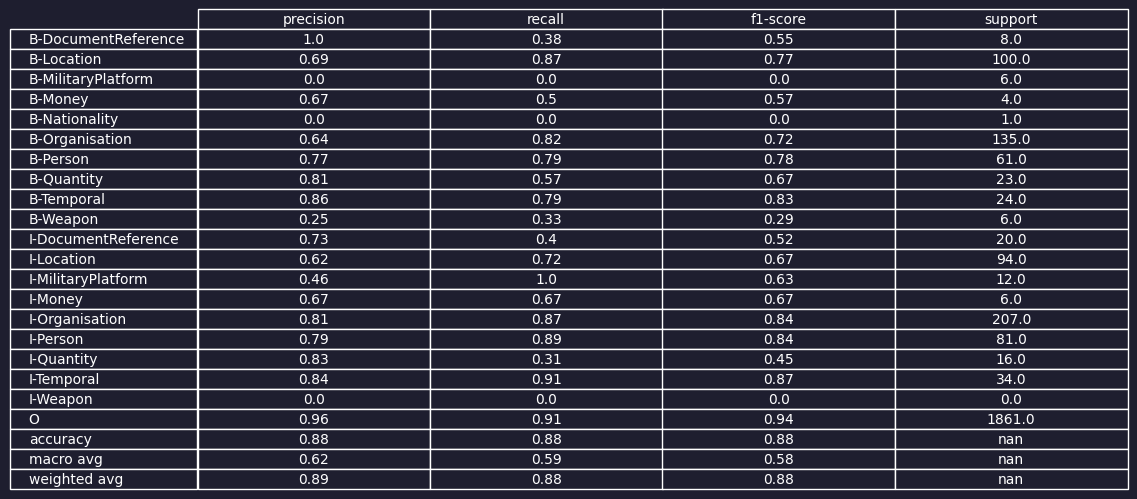

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

def compute_metrics(predictions, true_labels, tag2unique, ignore_index=-100, padding_value=0):
    all_predictions = []
    all_true_labels = []

    for pred, true in zip(predictions, true_labels):
        pred = np.array(pred)
        true = np.array(true)

        if pred.ndim == 0:
            pred = [pred]

        if true.ndim == 0:
            true = [true]

        all_predictions.extend(pred)
        all_true_labels.extend(true)

    assert len(all_predictions) == len(all_true_labels), f"Lunghezza mismatch dopo l'allineamento: {len(all_predictions)} vs {len(all_true_labels)}"


    mask = np.array(all_true_labels) != padding_value
    all_predictions = np.array(all_predictions)[mask]
    all_true_labels = np.array(all_true_labels)[mask]


    classification_rep = classification_report(all_true_labels, all_predictions, output_dict=True)
    metrics_df = pd.DataFrame(classification_rep).transpose()
    metrics_df = metrics_df.round(2)


    metrics_df.loc[['accuracy', 'macro avg', 'weighted avg'], 'support'] = None

    return metrics_df


def save_report_as_png(report_df, filename="classification_report.png"):
    fig, ax = plt.subplots(figsize=(10, 6))


    fig.patch.set_facecolor('#1E1E2F')
    ax.set_facecolor('#1E1E2F')
    ax.axis('off')


    table = plt.table(cellText=report_df.values,
                      colLabels=report_df.columns,
                      rowLabels=report_df.index,
                      cellLoc='center',
                      loc='center')


    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1.2, 1.2)


    for key, cell in table.get_celld().items():
        cell.set_facecolor('#1E1E2F')
        cell.set_edgecolor('white')
        cell.set_text_props(color='white')


    plt.savefig(filename, dpi=300, bbox_inches='tight', pad_inches=0.1, facecolor=fig.get_facecolor())
    plt.show()

predictions, true_labels = predict_tokens(test_dataset, model, tokenizer, tag2unique)
metrics = compute_metrics(predictions, true_labels, tag2unique)


save_report_as_png(metrics, "/content/drive/MyDrive/Colab Notebooks/BERT TRIAL 2/plots/report_bert.png")




The function compute_metrics is designed to evaluate the performance of a token classification model by comparing predicted labels against true labels. The function uses the classification_report from scikit-learn to compute metrics such as precision, recall, and F1-score.

It first initializes two empty lists: all_predictions and all_true_labels to store all predicted and true labels, respectively. The function iterates through each pair of predictions and true labels. If the prediction or true label is a single element (i.e., has no dimensions), it converts it into a list to ensure consistent processing.

Next, the function combines all the predictions and true labels into the lists all_predictions and all_true_labels. It then checks if the lengths of these two lists match, ensuring that the number of predictions corresponds to the number of true labels.

A mask is then applied to ignore certain values in the true labels. Specifically, the function filters out labels that are equal to ignore_index (usually for padding tokens) or 20, which could represent a special case like 'O' or a label to be ignored. The predictions and true labels are then filtered using this mask.

Finally, the function uses classification_report to compute a variety of classification metrics such as precision, recall, F1-score, and support for each label. It returns these metrics as a pandas DataFrame for easy analysis.

This function is useful for evaluating the quality of a model's predictions by comparing them to the ground truth in a detailed manner.

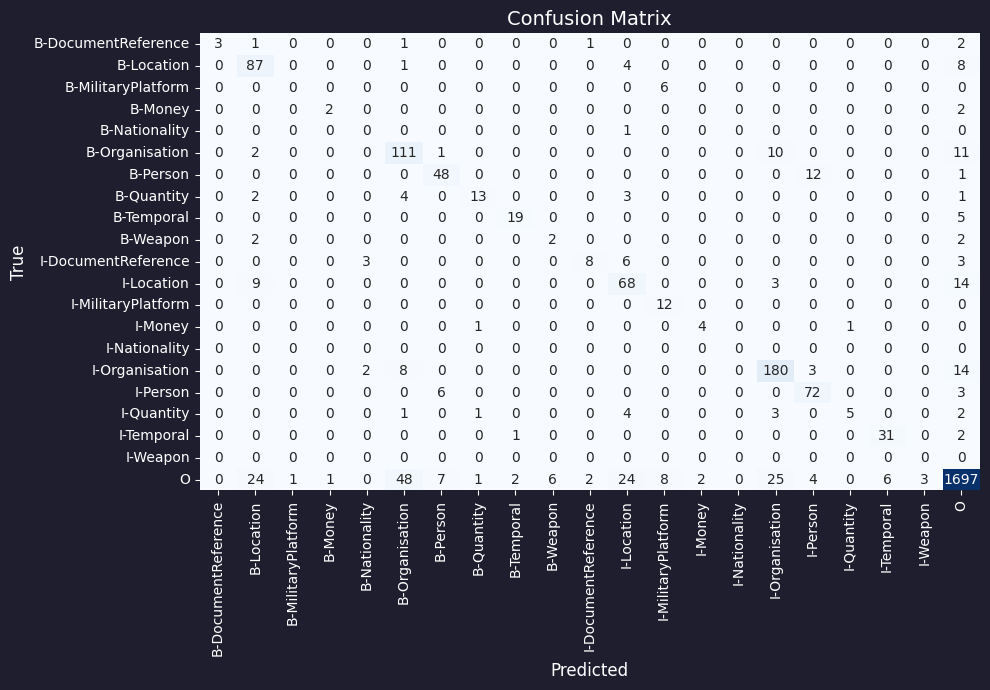

Grafico salvato in: /content/drive/MyDrive/Colab Notebooks/BERT TRIAL 2/plots/confusion_matrix1_bert.png


In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import os

def plot_confusion_matrix(cm, labels, save_dir):

    plt.figure(figsize=(10, 7), facecolor='#1E1E2F')
    ax = sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels, cbar=False)


    ax.set_xlabel('Predicted', fontsize=12, color='white')
    ax.set_ylabel('True', fontsize=12, color='white')
    ax.set_title('Confusion Matrix', fontsize=14, color='white')


    ax.tick_params(axis='x', colors='white')
    ax.tick_params(axis='y', colors='white')


    ax.set_facecolor('#1E1E2F')
    plt.tight_layout()


    confusion_matrix_plot_path = os.path.join(save_dir, 'confusion_matrix1_bert.png')
    plt.savefig(confusion_matrix_plot_path, facecolor='#1E1E2F')
    plt.show()

    print(f"Grafico salvato in: {confusion_matrix_plot_path}")

def compute_and_plot_confusion_matrix(predictions, true_labels, tag2unique, save_dir):
    unique2tag = {v: k for k, v in tag2unique.items()}

    all_true_labels = []
    all_predictions = []


    for pred, true in zip(predictions, true_labels):
        mask = np.array(true) != ''
        filtered_true = np.array(true)[mask]
        filtered_pred = np.array(pred)[mask]

        all_true_labels.extend(filtered_true)
        all_predictions.extend(filtered_pred)


    cm = confusion_matrix(all_true_labels, all_predictions, labels=[label for label in unique2tag.values() if label != ''])


    plot_confusion_matrix(cm, [label for label in unique2tag.values() if label != ''], save_dir)


save_dir = '/content/drive/MyDrive/Colab Notebooks/BERT TRIAL 2/plots'
os.makedirs(save_dir, exist_ok=True)


compute_and_plot_confusion_matrix(predictions, true_labels, tag2unique, save_dir)


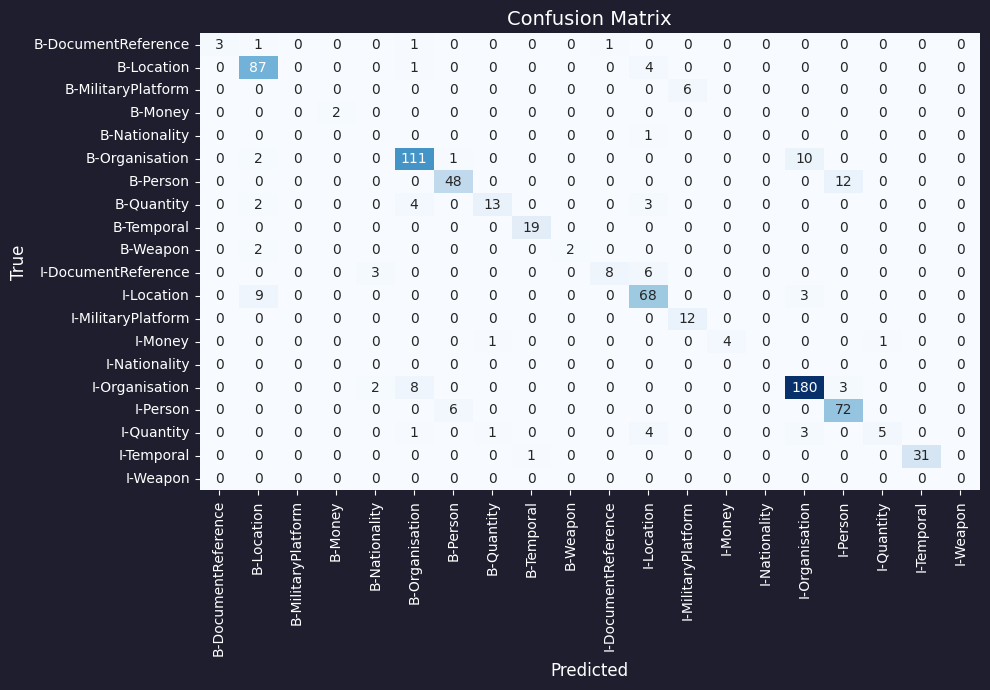

Grafico salvato in: /content/drive/MyDrive/Colab Notebooks/BERT TRIAL 2/plots/confusion_matrix2_bert.png


In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import os

def plot_confusion_matrix(cm, labels, save_dir):
    # Creazione della figura e impostazione dello sfondo blu scuro
    plt.figure(figsize=(10, 7), facecolor='#1E1E2F')
    ax = sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels, cbar=False)


    ax.set_xlabel('Predicted', fontsize=12, color='white')
    ax.set_ylabel('True', fontsize=12, color='white')
    ax.set_title('Confusion Matrix', fontsize=14, color='white')


    ax.tick_params(axis='x', colors='white')
    ax.tick_params(axis='y', colors='white')


    ax.set_facecolor('#1E1E2F')
    plt.tight_layout()


    confusion_matrix_plot_path = os.path.join(save_dir, 'confusion_matrix2_bert.png')
    plt.savefig(confusion_matrix_plot_path, facecolor='#1E1E2F')
    plt.show()

    print(f"Grafico salvato in: {confusion_matrix_plot_path}")

def compute_and_plot_confusion_matrix(predictions, true_labels, tag2unique, save_dir):
    unique2tag = {v: k for k, v in tag2unique.items()}

    all_true_labels = []
    all_predictions = []


    for pred, true in zip(predictions, true_labels):
        mask = np.array(true) != 'O'
        filtered_true = np.array(true)[mask]
        filtered_pred = np.array(pred)[mask]

        all_true_labels.extend(filtered_true)
        all_predictions.extend(filtered_pred)


    cm = confusion_matrix(all_true_labels, all_predictions, labels=[label for label in unique2tag.values() if label != 'O'])


    plot_confusion_matrix(cm, [label for label in unique2tag.values() if label != 'O'], save_dir)


save_dir = '/content/drive/MyDrive/Colab Notebooks/BERT TRIAL 2/plots'
os.makedirs(save_dir, exist_ok=True)

compute_and_plot_confusion_matrix(predictions, true_labels, tag2unique, save_dir)


<ipython-input-104-29dc71dc9eb2>:9: RuntimeWarning: invalid value encountered in divide
  cm_percentage = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100


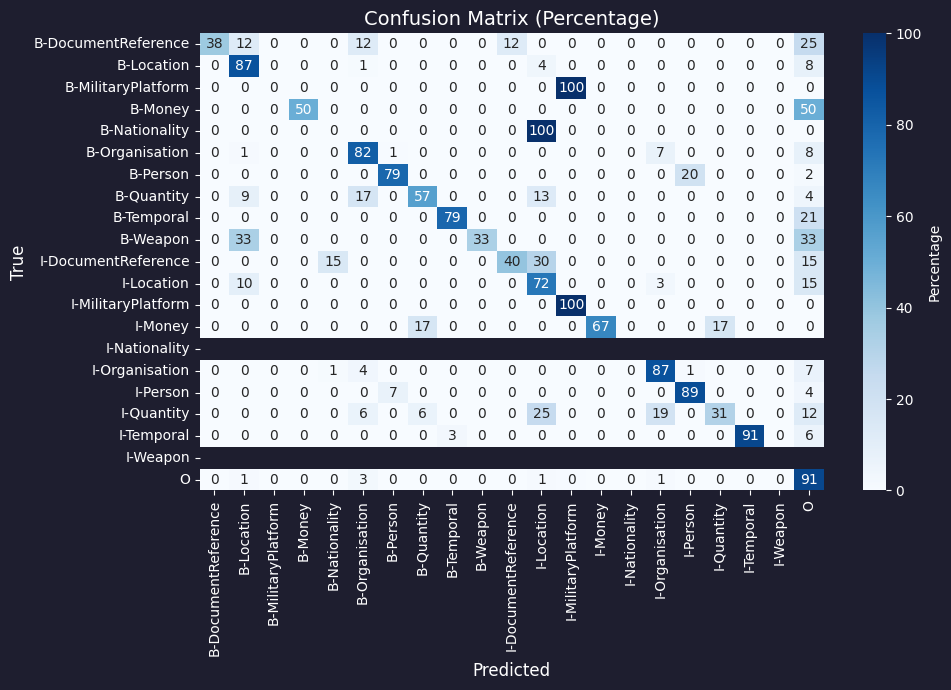

Grafico salvato in: /content/drive/MyDrive/Colab Notebooks/BERT TRIAL 2/plots/confusion_matrix_percentage_bert.png


In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import os

def plot_confusion_matrix(cm, labels, save_dir):

    cm_percentage = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100


    plt.figure(figsize=(10, 7), facecolor='#1E1E2F')
    ax = sns.heatmap(cm_percentage, annot=True, fmt='.0f', cmap='Blues', xticklabels=labels, yticklabels=labels, cbar_kws={'label': 'Percentage'})


    for text in ax.texts:
        text.set_fontsize(10)


    ax.set_xlabel('Predicted', fontsize=12, color='white')
    ax.set_ylabel('True', fontsize=12, color='white')
    ax.set_title('Confusion Matrix (Percentage)', fontsize=14, color='white')


    ax.tick_params(axis='x', colors='white')
    ax.tick_params(axis='y', colors='white')


    ax.set_facecolor('#1E1E2F')
    ax.collections[0].colorbar.ax.yaxis.set_tick_params(color='white')
    plt.setp(ax.collections[0].colorbar.ax.get_yticklabels(), color='white')


    plt.tight_layout()
    confusion_matrix_plot_path = os.path.join(save_dir, 'confusion_matrix_percentage_bert.png')
    plt.savefig(confusion_matrix_plot_path, facecolor='#1E1E2F')
    plt.show()

    print(f"Grafico salvato in: {confusion_matrix_plot_path}")

def compute_and_plot_confusion_matrix(predictions, true_labels, tag2unique, save_dir):
    unique2tag = {v: k for k, v in tag2unique.items()}

    all_true_labels = []
    all_predictions = []

    for pred, true in zip(predictions, true_labels):
        mask = np.array(true) != ''
        filtered_true = np.array(true)[mask]
        filtered_pred = np.array(pred)[mask]

        all_true_labels.extend(filtered_true)
        all_predictions.extend(filtered_pred)

    cm = confusion_matrix(all_true_labels, all_predictions, labels=[label for label in unique2tag.values() if label != ''])

    plot_confusion_matrix(cm, [label for label in unique2tag.values() if label != ''], save_dir)


save_dir = '/content/drive/MyDrive/Colab Notebooks/BERT TRIAL 2/plots'
os.makedirs(save_dir, exist_ok=True)

compute_and_plot_confusion_matrix(predictions, true_labels, tag2unique, save_dir)


# Conclusion

After implementing weights during training, the classification performance of both models has significantly improved. Nonetheless, the BERT model is better, particularly if comparing metrics that can account for class imbalance, like F1 Macro, which is the harmonic mean of precision and recall, and masked accuracy, which calculates the accuracy of the predictions by excluding the influence of the dominant class 'O'.  
Additionally, different loss functions have been implemented during training, like focal loss and weighted cross entropy loss, to counter the imbalance issue.